<a href="https://www.kaggle.com/code/adamdandi/2023-2025-training-performance-analysis?scriptVersionId=273652237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **2023–2025 Training Performance Analysis: Session Delivery Overview**

## **Introduction**

This document provides an overview of the training performance across **2023–2025**. It aims to analyse the number of sessions delivered during this period to understand the overall demand for each course. The analysis supports data-driven planning for future training programs and helps identify areas with higher participation or emerging needs. This aligns with the organisation’s goal to improve training effectiveness and resource allocation.

## **Objectives**

The key objectives of this documentation are to:

* Determine the total number of sessions delivered per course during **2023–2025**.
* Identify trends in session frequency across different training categories.
* Highlight areas of growth or decline to guide future program planning.
* Support decisions on course scheduling, instructor allocation, and resource investment.

Success will be measured by the clarity and accuracy of insights drawn from the data, enabling actionable planning for the next training cycle.

## **Scope**

The analysis covers all training sessions delivered between **January 2023 and December 2025**. It includes course titles, frequency, and participation data where available. The scope is limited to quantitative delivery metrics and does not include qualitative feedback or performance evaluation. All data is sourced from the internal training records and validated for consistency.

## **Methodology**

The analysis follows these key steps:

1. Collect and verify session data from the **2023–2025** training records.
2. Organise courses by category and delivery frequency.
3. Apply filters to identify patterns and variations in demand.
4. Summarise findings in tables and charts for clarity.

This structured approach ensures that the data is complete, accurate, and ready for interpretation.

## **Expected Outcomes**

The expected outcomes of this analysis include:

* A clear summary of session delivery volume for each course.
* Insights into training demand trends across the **three-year period**.
* Recommendations for strategic adjustments in future training plans.

The results will guide planning for the **2026 training calendar**, ensuring efficient use of resources and alignment with learner demand.

In [1]:
import pandas as pd
import warnings

# Suppress "serial value outside limits" warnings
with warnings.catch_warnings(record=True):
    warnings.simplefilter("ignore")

    # Read Excel without date parsing
    data = pd.read_excel(
        "/kaggle/input/trainingdata/TKI-Course-repository.xlsx",
        engine="openpyxl",
        parse_dates=False,  # ✅ correct parameter
        dtype=str            # ✅ read everything as text to avoid Excel date conversion
    )

# Check Data Structure
print("Data Structure:")
print(data.info())

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42450 entries, 0 to 42449
Data columns (total 53 columns):
 #   Column                                                                                                                                                                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                          --------------  ----- 
 0   https://www.linkedin.com/profile/view?id=32701032&authType=NAME_SEARCH&authToken=xxDe&locale=en_US&srchid=1285069551424960135798&srchindex=1&srchtotal=1&trk=vsrp_people_res_name&trkInfo=VSRPsearchId%3A1285069551424960135798%2CVSRPtargetId%3A32701032%2CVSRPcmpt%3Aprimary

### **Data Preparation**

This step creates a structured dataset focused on analyzing course sessions delivered between **2023 and 2025**. The process involves selecting relevant fields, standardizing date formats, and filtering by year to ensure clean and consistent data for analysis.

- **Column Selection:**  
  From the original dataset, nine key columns are retained to capture essential course and scheduling details:  
  **Organizer**, **Facilitator**, **Course Title**, **Course Structure**, **Method**, **Start Date**, **End Date**, **Course City**, and **Course Country**.  
  These columns provide complete coverage of delivery, timing, and location aspects, removing unrelated fields to improve efficiency and clarity.

- **Date Standardization:**  
  A robust multi-pass date parser converts all date values into a consistent format.  
  It handles:
  - Excel serial numbers (e.g., `45250` → valid date).  
  - Day-first formats (`28.09.2025`, `28/09/2025`, `28-09-2025`).  
  - Year-first ISO formats (`2025-09-28`, `2025/09/28`).  
  - Month-first fallbacks (`09/28/2025`).  
  The cleaned results are stored in two new columns — **`Start date std`** and **`End date std`**.

- **Filtering by Year:**  
  The dataset is filtered to include only sessions where either the start or end date falls within **2023, 2024, or 2025**.  
  Any sessions with dates from **2022** are explicitly removed to keep the analysis focused on recent delivery activity.

- **Verification Output:**  
  The script prints the total number of valid rows and displays the first and last 20 records to confirm accuracy after filtering and parsing.

In [2]:
# Use the existing dataframe named `data`
# Keep ONLY these columns
selected_columns = [
    'Organizer',
    'Facilitator',
    'Course title',
    'Course structure',
    'Method',
    'Start date',
    'End date',
    'Course city',
    'Course country',
]

# Create the working dataset named `course`
course = data[selected_columns].copy()

# ---------- Robust multi-pass date parser (handles '.', '/', '-' and Excel serials) ----------
def parse_dates(s: pd.Series) -> pd.Series:
    # Clean once
    s = s.astype('string').str.strip()

    # 1) Excel serials first (accept '45250' and '45250.0'; avoid short numbers like '2025')
    ser_mask = s.str.fullmatch(r'\d{5,}(?:\.0+)?')
    ser = pd.to_numeric(s.where(ser_mask).str.replace(r'\.0+$', '', regex=True), errors='coerce')
    out = pd.to_datetime(ser, unit='d', origin='1899-12-30', errors='coerce')

    # 2) Day-first strings: '28.09.2025', '28/9/2025', '28-09-2025'
    m = out.isna()
    out[m] = pd.to_datetime(s[m], dayfirst=True, errors='coerce', cache=True)

    # 3) Year-first (ISO etc.): '2025-09-28', '2025/09/28'
    m = out.isna()
    out[m] = pd.to_datetime(s[m], yearfirst=True, errors='coerce', cache=True)

    # 4) Last-chance month-first: '09/28/2025'
    m = out.isna()
    out[m] = pd.to_datetime(s[m], errors='coerce', cache=True)

    return out
# --------------------------------------------------------------------------------------------

# Create standardized datetime columns
course['Start date std'] = parse_dates(course['Start date'])
course['End date std']   = parse_dates(course['End date'])

# Keep ONLY rows where Start date std OR End date std is in 2023/2024/2025
valid_years = {2023, 2024, 2025}
mask_years = (
    course['Start date std'].dt.year.isin(valid_years) |
    course['End date std'].dt.year.isin(valid_years)
)
course = course[mask_years].reset_index(drop=True)
# Explicitly exclude any row where Start/End std is in 2022
course = course[~(course['Start date std'].dt.year.eq(2022) | course['End date std'].dt.year.eq(2022))].reset_index(drop=True)

# (Optional) quick look
print("Filtered rows (years 2023–2025 in Start/End std):", len(course))
display(course.head(20))
display(course.tail(20))

Filtered rows (years 2023–2025 in Start/End std): 17356


/tmp/ipykernel_13/665655471.py:30: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  out[m] = pd.to_datetime(s[m], dayfirst=True, errors='coerce', cache=True)
/tmp/ipykernel_13/665655471.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out[m] = pd.to_datetime(s[m], yearfirst=True, errors='coerce', cache=True)
/tmp/ipykernel_13/665655471.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out[m] = pd.to_datetime(s[m], errors='coerce', cache=True)
/tmp/ipykernel_13/665655471.py:30: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence thi

Organizer           Facilitator Course title Course structure  \
0   Somu Training        Teodora Gorski        C-BSC         In-house   
1             TKI  Malek Mohammed Ghazo          C-B             Open   
2             TKI  Malek Mohammed Ghazo          C-B             Open   
3             TKI         Adrian Brudan        C-KPI             Open   
4             TKI          Codruta Mare         C-DV         In-house   
5             TKI          Codruta Mare         C-DV         In-house   
6             TKI            Mihai Toma        C-BSC         In-house   
7             TKI            Mihai Toma        C-BSC         In-house   
8             TKI            Mihai Toma        C-BSC         In-house   
9             TKI            Mihai Toma        C-BSC         In-house   
10            TKI            Mihai Toma        C-BSC         In-house   
11            TKI            Mihai Toma        C-BSC         In-house   
12            TKI            Mihai Toma        C-BSC         In-house   
13            TKI            Mihai Toma        C-BSC         In-house   
14            TKI            Mihai Toma        C-BSC         In-house   
15            TKI            Mihai Toma        C-BSC         In-house   
16            TKI            Mihai Toma        C-BSC         In-house   
17            TKI            Mihai Toma        C-BSC         In-house   
18            TKI            Mihai Toma        C-BSC         In-house   
19            TKI            Mihai Toma        C-BSC         In-house   

          Method           Start date             End date Course city  \
0   Face to face           17/11/2023           19/11/2023      Dammam   
1           Live           18/04/2023           22/04/2023         NaN   
2           Live           18/04/2023           22/04/2023         NaN   
3           Live           19/09/2023           23/09/2023         NaN   
4   Face to face           27/11/2023           29/11/2023      Riyadh   
5   Face to face           27/11/2024           29/11/2024      Riyadh   
6           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
7           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
8           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
9           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
10          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
11          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
12          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
13          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
14          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
15          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
16          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
17          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
18          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
19          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   

   Course country Start date std End date std  
0    Saudi Arabia     2023-11-17   2023-11-19  
1             NaN     2023-04-18   2023-04-22  
2             NaN     2023-04-18   2023-04-22  
3             NaN     2023-09-19   2023-09-23  
4    Saudi Arabia     2023-11-27   2023-11-29  
5    Saudi Arabia     2024-11-27   2024-11-29  
6             NaN     2023-08-01   2023-12-01  
7             NaN     2023-08-01   2023-12-01  
8             NaN     2023-08-01   2023-12-01  
9             NaN     2023-08-01   2023-12-01  
10            NaN     2023-08-01   2023-12-01  
11            NaN     2023-08-01   2023-12-01  
12            NaN     2023-08-01   2023-12-01  
13            NaN     2023-08-01   2023-12-01  
14            NaN     2023-08-01   2023-12-01  
15            NaN     2023-08-01   2023-12-01  
16            NaN     2023-08-01   2023-12-01  
17            NaN     2023-08-01   2023-12-01  
18     

Organizer     Facilitator Course title Course structure        Method  \
17336       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17337       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17338       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17339       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17340       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17341       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17342       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17343       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17344       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17345       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17346       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17347       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17348       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17349       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17350       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17351       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17352       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17353       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17354       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17355       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   

       Start date    End date Course city Course country Start date std  \
17336  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17337  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17338  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17339  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17340  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17341  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17342   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17343   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17344   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17345   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17346   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17347   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17348   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17349   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17350   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17351   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17352   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17353   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17354   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17355   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   

      End date std  
17336   2025-09-30  
17337   2025-09-30  
17338   2025-09-30  
17339   2025-09-30  
17340   2025-09-30  
17341   2025-09-30  
17342   2025-10-02  
17343   2025-10-02  
17344   2025-10-02  
17345   2025-10-02  
17346   2025-10-02  
17347   2025-10-02  
17348   2025-10-02  
17349   2025-10-02  
17350   2025-10-02  
17351   2025-10-02  
17352   2025-10-02  
17353   2025-10-02  
17354   2025-10-02  
17355   2025-10-02

### Duplicate Check and Participant Count

In this step, we define one session and count how many participant records belong to it. This helps us measure session volume without changing the source data.

#### Session Rule
A session is the unique combination of four columns: **Facilitator**, **Course Title**, **Method**, **Start Date**, and **End Date**.

#### What We Do
1. Find duplicate rows based on the four columns above.  
2. Add a new column **Participants Count**, which stores the size of each group defined by the four columns.  
3. For any row with no duplicate, set **Participants Count** to 1. This column has no missing values.  
4. Produce three checks for quick validation:  
   - **Total rows**: the number of records in the filtered dataset.  
   - **Total participants count**: the sum of *Participants Count* across unique sessions. This equals the number of rows.  
   - **Total sessions**: the number of unique combinations of the four key columns.  
5. Show a short preview so we can confirm the result.

#### Assumptions and Guardrails
- We do not change the data type of any existing column.  
- We only add the **Participants Count** column.  
- All four grouping columns must be present and readable in the dataset.

In [3]:
# Define the session key
key_cols = ['Facilitator', 'Course title', 'Start date', 'End date']

# Count rows per unique session, aligned back to each row
group_sizes = course.groupby(key_cols, dropna=False).size()
course['Participants count'] = course[key_cols].merge(
    group_sizes.rename('Participants count').reset_index(),
    on=key_cols,
    how='left'
)['Participants count']

# Safety check: ensure no missing values in the new column, default to 1 if any appear
course['Participants count'] = course['Participants count'].fillna(1).astype(int)

# Summary numbers
total_rows = len(course)
total_sessions = group_sizes.shape[0]
total_participants = int(group_sizes.sum())  # equals total_rows by construction

# Print summaries
print("Total rows:", total_rows)
print("Total participants count:", total_participants)
print("Total sessions:", total_sessions)

# Preview
print("\nPreview:")
display(course.head(20))   # top 20
display(course.tail(20))   # bottom 20

Total rows: 17356
Total participants count: 17356
Total sessions: 1055

Preview:


Organizer           Facilitator Course title Course structure  \
0   Somu Training        Teodora Gorski        C-BSC         In-house   
1             TKI  Malek Mohammed Ghazo          C-B             Open   
2             TKI  Malek Mohammed Ghazo          C-B             Open   
3             TKI         Adrian Brudan        C-KPI             Open   
4             TKI          Codruta Mare         C-DV         In-house   
5             TKI          Codruta Mare         C-DV         In-house   
6             TKI            Mihai Toma        C-BSC         In-house   
7             TKI            Mihai Toma        C-BSC         In-house   
8             TKI            Mihai Toma        C-BSC         In-house   
9             TKI            Mihai Toma        C-BSC         In-house   
10            TKI            Mihai Toma        C-BSC         In-house   
11            TKI            Mihai Toma        C-BSC         In-house   
12            TKI            Mihai Toma        C-BSC         In-house   
13            TKI            Mihai Toma        C-BSC         In-house   
14            TKI            Mihai Toma        C-BSC         In-house   
15            TKI            Mihai Toma        C-BSC         In-house   
16            TKI            Mihai Toma        C-BSC         In-house   
17            TKI            Mihai Toma        C-BSC         In-house   
18            TKI            Mihai Toma        C-BSC         In-house   
19            TKI            Mihai Toma        C-BSC         In-house   

          Method           Start date             End date Course city  \
0   Face to face           17/11/2023           19/11/2023      Dammam   
1           Live           18/04/2023           22/04/2023         NaN   
2           Live           18/04/2023           22/04/2023         NaN   
3           Live           19/09/2023           23/09/2023         NaN   
4   Face to face           27/11/2023           29/11/2023      Riyadh   
5   Face to face           27/11/2024           29/11/2024      Riyadh   
6           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
7           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
8           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
9           Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
10          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
11          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
12          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
13          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
14          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
15          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
16          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
17          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
18          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   
19          Live  2023-08-01 00:00:00  2023-12-01 00:00:00         NaN   

   Course country Start date std End date std  Participants count  
0    Saudi Arabia     2023-11-17   2023-11-19                   1  
1             NaN     2023-04-18   2023-04-22                   2  
2             NaN     2023-04-18   2023-04-22                   2  
3             NaN     2023-09-19   2023-09-23                   1  
4    Saudi Arabia     2023-11-27   2023-11-29                   1  
5    Saudi Arabia     2024-11-27   2024-11-29                   1  
6             NaN     2023-08-01   2023-12-01                  16  
7             NaN     2023-08-01   2023-12-01                  16  
8             NaN     2023-08-01   2023-12-01                  16  
9             NaN     2023-08-01   2023-12-01                  16  
10            NaN     2023-08-01   2023-12-01                  16  
11            NaN     2023-08-01   2023-12-01                  16  
12            NaN     2023-08-01   

Organizer     Facilitator Course title Course structure        Method  \
17336       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17337       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17338       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17339       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17340       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17341       TKI  Andrea Minelli        C-KPI         In-house  Face to face   
17342       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17343       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17344       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17345       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17346       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17347       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17348       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17349       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17350       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17351       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17352       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17353       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17354       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   
17355       GIA  Yasser Ghonimy      C-KPIPP         In-house  Face to face   

       Start date    End date Course city Course country Start date std  \
17336  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17337  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17338  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17339  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17340  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17341  28.09.2025  30.09.2025      Riyadh   Saudi Arabia     2025-09-28   
17342   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17343   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17344   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17345   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17346   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17347   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17348   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17349   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17350   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17351   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17352   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17353   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17354   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   
17355   28.9.2025   2.10.2025      Riyadh   Saudi Arabia     2025-09-28   

      End date std  Participants count  
17336   2025-09-30                  13  
17337   2025-09-30                  13  
17338   2025-09-30                  13  
17339   2025-09-30                  13  
17340   2025-09-30                  13  
17341   2025-09-30                  13  
17342   2025-10-02                  14  
17343   2025-10-02                  14  
17344   2025-10-02                  14  
17345   2025-10-02                  14  
17346   2025-10-02                  14  
17347   2025-10-02                  14  
17348   2025-10-02                  14  
17349   2025-10-02                  14  
17350   2025-10-02                  14  
17351   2025-10-02                  14  
17352   2025-10-02                  14  
17353   2025-10-02              

### Remove duplicates, keep one row per session

We will drop duplicate rows using the session keys, Facilitator, Course title, Start date, End date. We keep the first row of each session. The Participants count column already stores the group size, so the kept row holds the correct count. No other column types change.

In [4]:
# Keys that define one session
key_cols = ['Facilitator', 'Course title', 'Start date', 'End date']

# Remove duplicates, keep the first row per session
course_dedup = course.drop_duplicates(subset=key_cols, keep='first').copy()

# Quick checks
print("Rows before:", len(course))
print("Rows after :", len(course_dedup))
print("Rows removed:", len(course) - len(course_dedup))

print("\nPreview after dedupe:")
display(course_dedup.head())

Rows before: 17356
Rows after : 1055
Rows removed: 16301

Preview after dedupe:


Organizer           Facilitator Course title Course structure  \
0  Somu Training        Teodora Gorski        C-BSC         In-house   
1            TKI  Malek Mohammed Ghazo          C-B             Open   
3            TKI         Adrian Brudan        C-KPI             Open   
4            TKI          Codruta Mare         C-DV         In-house   
5            TKI          Codruta Mare         C-DV         In-house   

         Method  Start date    End date Course city Course country  \
0  Face to face  17/11/2023  19/11/2023      Dammam   Saudi Arabia   
1          Live  18/04/2023  22/04/2023         NaN            NaN   
3          Live  19/09/2023  23/09/2023         NaN            NaN   
4  Face to face  27/11/2023  29/11/2023      Riyadh   Saudi Arabia   
5  Face to face  27/11/2024  29/11/2024      Riyadh   Saudi Arabia   

  Start date std End date std  Participants count  
0     2023-11-17   2023-11-19                   1  
1     2023-04-18   2023-04-22                   2  
3     2023-09-19   2023-09-23                   1  
4     2023-11-27   2023-11-29                   1  
5     2024-11-27   2024-11-29                   1

In [5]:
# Check if there are still duplicates after the cleaning process
remaining_duplicates = course_dedup[course_dedup.duplicated(subset=['Facilitator', 'Course title', 'Start date', 'End date'], keep=False)]

# Display the results
if len(remaining_duplicates) == 0:
    print("✅ No duplicates remain. The data is clean.")
else:
    print(f"⚠️ There are still {len(remaining_duplicates)} duplicates remaining.")
    display(remaining_duplicates.head())

✅ No duplicates remain. The data is clean.


In [6]:
print(course_dedup.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 0 to 17342
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Organizer           1055 non-null   object        
 1   Facilitator         1055 non-null   object        
 2   Course title        1055 non-null   object        
 3   Course structure    1047 non-null   object        
 4   Method              1054 non-null   object        
 5   Start date          1055 non-null   object        
 6   End date            1048 non-null   object        
 7   Course city         490 non-null    object        
 8   Course country      490 non-null    object        
 9   Start date std      1054 non-null   datetime64[ns]
 10  End date std        1043 non-null   datetime64[ns]
 11  Participants count  1055 non-null   int64         
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 107.1+ KB
None


In [7]:
# Configure the table to scroll
def table(df, height=400):
    display(df.style.set_table_attributes(f'style="display:inline-block;overflow:auto;height:{height}px;width:auto;"').set_table_styles([{
        'selector': '',
        'props': [('border-collapse', 'collapse'),
                  ('margin', '0px')]}]))

# Display the table
table(course_dedup)

In [8]:
# Export cleaned data to Excel file
output_path = '/kaggle/working/Course-Season-2023-2025-Participants.xlsx'
course_dedup.to_excel(output_path, index=False)

print(f"✅ Data successfully exported to: {output_path}")

✅ Data successfully exported to: /kaggle/working/Course-Season-2023-2025-Participants.xlsx


### Duration & Quality Checks

**What this step does (using `course_dedup`):**

1. **Duration math (inclusive):**
   Creates `Duration (days)` as
   `End date std − Start date std + 1`,
   so a one-day course counts as **1** (not 0).

2. **Targeted flags (`suspicious_mask`):**
   Marks rows for review when:

   * `Duration (days) < 1` → end before start (likely parse/data issue) and same date, or
   * `Duration (days) > 15` → unusually long course.

3. **Clear outputs for review:**

   * **Rows with suspicious durations:** shows key columns plus `Start date std`, `End date std`, and `Duration (days)`.
   * **Rows with unparsed dates (NaT):** any row where either `Start date std` or `End date std` is missing.

4. **Summary counters:**
   Prints total rows in `course_dedup`, count of **NaT** rows, and count of **suspicious** rows.

In [9]:
# ---- NEXT STEP: duration math, flags, and review tables (use course_dedup) ----
# Assumes `course_dedup` already has parsed columns: 'Start date std' and 'End date std'

# 1) Duration (inclusive) — a one-day course = 1 day
course_dedup['Duration (days)'] = (
    course_dedup['End date std'] - course_dedup['Start date std']
).dt.days + 1

# 2) Targeted flags
#    - Duration < 2  : end before start (likely parsing/data error) and same date check
#    - Duration > 15 : unusually long, needs review
suspicious_mask = (course_dedup['Duration (days)'] < 2) | (course_dedup['Duration (days)'] > 15)

# 3) Clear outputs
#    a) Rows with unparsed dates (either std date is NaT)
nat_mask = course_dedup['Start date std'].isna() | course_dedup['End date std'].isna()
nat_table = course_dedup.loc[nat_mask, [
    'Organizer', 'Facilitator', 'Course title', 'Course structure', 'Method', 'Participants count',
    'Start date', 'End date', 'Course city', 'Course country'
]]

#    b) Rows with suspicious durations
suspicious_table = course_dedup.loc[suspicious_mask, [
    'Organizer', 'Facilitator', 'Course title', 'Course structure', 'Method', 'Participants count',
    'Start date', 'End date', 'Start date std', 'End date std',
    'Duration (days)', 'Course city', 'Course country'
]]

# 4) Summary + displays
rows_total = len(course_dedup)
nat_count = nat_mask.sum()
suspicious_count = suspicious_mask.sum()

print(f"Total rows (dedup): {rows_total}")
print(f"Rows with unparsed dates (NaT): {nat_count}")
print(f"Rows with suspicious durations (<1 or >15 days): {suspicious_count}\n")

print(" ROWS WITH SUSPICIOUS DURATION ")
display(suspicious_table)

print("\n ROWS THAT FAILED TO PARSE (NaT) ")
display(nat_table)

Total rows (dedup): 1055
Rows with unparsed dates (NaT): 13
Rows with suspicious durations (<1 or >15 days): 488

 ROWS WITH SUSPICIOUS DURATION 


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Organizer         Facilitator             Course title  \
6            TKI          Mihai Toma                    C-BSC   
22           TKI          Alin Sonda                    C-EPM   
233          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
249          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
268          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
...          ...                 ...                      ...   
17071        RHO      Yasser Ghonimy                    C-KPI   
17085  Vigilance  Dr. Raed Al-Jowder                    C-KPI   
17091      iLead   Abdulaziz Hussein                  C-KPIPP   
17116       MILE    Ahmed Al-Zahrani                    C-KPI   
17292        TKI         Radu Cocean                    C-SBP   

      Course structure        Method  Participants count           Start date  \
6             In-house          Live                  16  2023-08-01 00:00:00   
22                Open          Live                   5  2023-09-01 00:00:00   
233           In-house          Live                  16           22/01/2023   
249           In-house          Live                  19           23/01/2023   
268           In-house          Live                  20           24/01/2023   
...                ...           ...                 ...                  ...   
17071             Open          Live                  14  2025-06-09 00:00:00   
17085             Open          Live                   6           07.09.2025   
17091         In-house  Face to face                  25             7.9.2025   
17116         In-house  Face to face                  11  2025-07-09 00:00:00   
17292             Open          Live                  26           29/09/2025   

                  End date Start date std End date std  Duration (days)  \
6      2023-12-01 00:00:00     2023-08-01   2023-12-01            123.0   
22              13/01/2023     2023-09-01   2023-01-13           -230.0   
233             22/01/2023     2023-01-22   2023-01-22              1.0   
249             23/01/2023     2023-01-23   2023-01-23              1.0   
268             24/01/2023     2023-01-24   2023-01-24              1.0   
...                    ...            ...          ...              ...   
17071  2025-10-09 00:00:00     2025-06-09   2025-10-09            123.0   
17085           11.09.2025     2025-07-09   2025-09-11             65.0   
17091            11.9.2025     2025-07-09   2025-09-11             65.0   
17116  2025-09-09 00:00:00     2025-07-09   2025-09-09             63.0   
17292  2025-03-10 00:00:00     2025-09-29   2025-03-10           -202.0   

      Course city Course country  
6             NaN            NaN  
22            NaN            NaN  
233           NaN            NaN  
249           NaN            NaN  
268           NaN            NaN  
...           ...            ...  
17071         NaN            NaN  
17085         NaN            NaN  
17091      Riyadh   Saudi Arabia  
17116      Riyadh   Saudi Arabia  
17292         NaN            NaN  

[488 rows x 13 columns]


 ROWS THAT FAILED TO PARSE (NaT) 


Organizer          Facilitator Course title Course structure  \
380                TKI          Radu Cocean        KPI-E         In-house   
577                TKI           Alin Sonda    KPI-EPM-A         In-house   
588                TKI           Alin Sonda    KPI-EPM-A         In-house   
2366               TKI       Raluca Vintila        KPI-E         In-house   
3758   Beyond Paradigm       Farhan Mahmood        KPI-E         In-house   
3766   Beyond Paradigm       Farhan Mahmood        KPI-E         In-house   
6921               TKI       Yasser Ghonimy        C-SBP             Open   
7831               TKI    Dr. Ziyad Jawabra         C-PM             Open   
7889               TKI          Radu Cocean         C-PM         In-house   
8118         Vigilance  Dr. Saleh Al-Ansari        C-KPI         In-house   
8778     Strategic KPI       Yassine Chaker        C-KPI         In-house   
10327              TKI          Radu Cocean        KPI-E         In-house   
15544              TKI       Yassine Chaker          C-B             Open   

             Method  Participants count           Start date       End date  \
380    Face to face                  15  2023-12-01 00:00:00            NaN   
577    Face to face                  11  2023-09-02 00:00:00            NaN   
588    Face to face                  15  2023-08-02 00:00:00            NaN   
2366           Live                  25  2023-04-07 00:00:00            NaN   
3758   Face to face                   8           19/09/2023            NaN   
3766   Face to face                  20           18/09/2023            NaN   
6921           Live                   1           25/02/2025     29/02/2025   
7831           Live                  11  2024-06-05 00:00:00     10.05/2024   
7889           Live                  13  2024-08-05 00:00:00  12-15/05/2024   
8118           Live                  23           19/05/2024    223/05/2024   
8778           Live                   8         8-10/07/2024     18/07/2024   
10327  Face to face                  40           15/07/2024            NaN   
15544          Live                   5            22/6/2025     26/6/20225   

      Course city Course country  
380        Dammam   Saudi Arabia  
577        Riyadh   Saudi Arabia  
588        Riyadh   Saudi Arabia  
2366          NaN            NaN  
3758    Islamabad       Pakistan  
3766   Rawalpindi       Pakistan  
6921          NaN            NaN  
7831          NaN            NaN  
7889          NaN            NaN  
8118          NaN            NaN  
8778          NaN            NaN  
10327      Riyadh   Saudi Arabia  
15544         NaN            NaN

### **Data Cleaning & Validation Plan**

#### **1. Identify Ambiguity**  
For each date in the `suspicious_table`, check if both the **day** and **month** fall between 1 and 12.  
This helps detect potentially ambiguous dates that may have been misinterpreted due to mixed formats (e.g., `03/07` could mean **March 7** or **July 3**).

#### **2. Create a Flag**  
Add a new column that **flags rows with ambiguous dates**.  
This makes it easy to isolate and review problematic entries before applying corrections.

#### **3. Swap Day and Month**  
For all **flagged dates**, swap the **day** and **month** values.  
This corrects possible day/month parsing errors caused by differing date conventions (e.g., **US vs. EU** formats).

#### **4. Recalculate Duration**  
After correcting dates, **recalculate the duration** (e.g., between `start_date` and `end_date`) to ensure logical and consistent time intervals.

#### **5. Show Before & After**  
Produce a **comparison table** displaying both versions:
- Original (ambiguous) data  
- Corrected (cleaned) data  

This visual check verifies the accuracy of the cleaning process before finalizing the dataset.

In [10]:
# Create a copy to work on, preserving the original table
resolved_table = suspicious_table.copy()

print(" Original Suspicious Table ")
print("Notice 'Course B' has a negative duration, indicating a parsing error.")
display(suspicious_table)


# 1. Define a function to check if a date is ambiguous (day and month are 1-12)
def is_date_ambiguous(dt):
    """Returns True if a datetime object's day and month are both between 1 and 12."""
    if pd.isna(dt):
        return False
    return 1 <= dt.day <= 12 and 1 <= dt.month <= 12

# 2. Apply this function to create boolean flags for start and end dates
resolved_table['start_is_ambiguous'] = resolved_table['Start date std'].apply(is_date_ambiguous)
resolved_table['end_is_ambiguous'] = resolved_table['End date std'].apply(is_date_ambiguous)

# Create a single flag for the entire row
resolved_table['Ambiguous Flag'] = resolved_table['start_is_ambiguous'] | resolved_table['end_is_ambiguous']


# 3. Define a function to swap the day and month of a datetime object
def swap_day_month(dt):
    """Returns a new datetime object with the day and month swapped."""
    if pd.isna(dt):
        return pd.NaT
    # Create a new Timestamp to avoid errors with non-existent dates (e.g., 31st of Feb)
    return pd.Timestamp(year=dt.year, month=dt.day, day=dt.month)


# 4. Create new 'resolved' columns
# Initialize them with the original dates
resolved_table['Start date resolved'] = resolved_table['Start date std']
resolved_table['End date resolved'] = resolved_table['End date std']

# Conditionally apply the swap only where the dates were flagged as ambiguous
resolved_table.loc[resolved_table['start_is_ambiguous'], 'Start date resolved'] = resolved_table.loc[resolved_table['start_is_ambiguous'], 'Start date std'].apply(swap_day_month)
resolved_table.loc[resolved_table['end_is_ambiguous'], 'End date resolved'] = resolved_table.loc[resolved_table['end_is_ambiguous'], 'End date std'].apply(swap_day_month)


# 5. Recalculate the duration based on the new 'resolved' dates
new_duration = (resolved_table['End date resolved'] - resolved_table['Start date resolved'])
resolved_table['Duration resolved (days)'] = new_duration.dt.days + 1


# 6. Create the final "Before and After" comparison table for easy review
comparison_view = resolved_table[[
    'Course title',
    'Start date std',
    'End date std',
    'Duration (days)',
    'Ambiguous Flag',
    'Start date resolved',
    'End date resolved',
    'Duration resolved (days)'
]].copy()

# Format dates for clearer display
for col in ['Start date std', 'End date std', 'Start date resolved', 'End date resolved']:
    comparison_view[col] = comparison_view[col].dt.strftime('%Y-%m-%d')


print("\n\n Corrected Dates and Durations (Comparison View) ")
print("The 'resolved' columns show the corrected dates and logical durations.")
display(comparison_view)

 Original Suspicious Table 
Notice 'Course B' has a negative duration, indicating a parsing error.


Organizer         Facilitator             Course title  \
6            TKI          Mihai Toma                    C-BSC   
22           TKI          Alin Sonda                    C-EPM   
233          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
249          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
268          TKI      Alina Miertoiu  C-KPI & C-OKR Awareness   
...          ...                 ...                      ...   
17071        RHO      Yasser Ghonimy                    C-KPI   
17085  Vigilance  Dr. Raed Al-Jowder                    C-KPI   
17091      iLead   Abdulaziz Hussein                  C-KPIPP   
17116       MILE    Ahmed Al-Zahrani                    C-KPI   
17292        TKI         Radu Cocean                    C-SBP   

      Course structure        Method  Participants count           Start date  \
6             In-house          Live                  16  2023-08-01 00:00:00   
22                Open          Live                   5  2023-09-01 00:00:00   
233           In-house          Live                  16           22/01/2023   
249           In-house          Live                  19           23/01/2023   
268           In-house          Live                  20           24/01/2023   
...                ...           ...                 ...                  ...   
17071             Open          Live                  14  2025-06-09 00:00:00   
17085             Open          Live                   6           07.09.2025   
17091         In-house  Face to face                  25             7.9.2025   
17116         In-house  Face to face                  11  2025-07-09 00:00:00   
17292             Open          Live                  26           29/09/2025   

                  End date Start date std End date std  Duration (days)  \
6      2023-12-01 00:00:00     2023-08-01   2023-12-01            123.0   
22              13/01/2023     2023-09-01   2023-01-13           -230.0   
233             22/01/2023     2023-01-22   2023-01-22              1.0   
249             23/01/2023     2023-01-23   2023-01-23              1.0   
268             24/01/2023     2023-01-24   2023-01-24              1.0   
...                    ...            ...          ...              ...   
17071  2025-10-09 00:00:00     2025-06-09   2025-10-09            123.0   
17085           11.09.2025     2025-07-09   2025-09-11             65.0   
17091            11.9.2025     2025-07-09   2025-09-11             65.0   
17116  2025-09-09 00:00:00     2025-07-09   2025-09-09             63.0   
17292  2025-03-10 00:00:00     2025-09-29   2025-03-10           -202.0   

      Course city Course country  
6             NaN            NaN  
22            NaN            NaN  
233           NaN            NaN  
249           NaN            NaN  
268           NaN            NaN  
...           ...            ...  
17071         NaN            NaN  
17085         NaN            NaN  
17091      Riyadh   Saudi Arabia  
17116      Riyadh   Saudi Arabia  
17292         NaN            NaN  

[488 rows x 13 columns]



 Corrected Dates and Durations (Comparison View) 
The 'resolved' columns show the corrected dates and logical durations.


Course title Start date std End date std  Duration (days)  \
6                        C-BSC     2023-08-01   2023-12-01            123.0   
22                       C-EPM     2023-09-01   2023-01-13           -230.0   
233    C-KPI & C-OKR Awareness     2023-01-22   2023-01-22              1.0   
249    C-KPI & C-OKR Awareness     2023-01-23   2023-01-23              1.0   
268    C-KPI & C-OKR Awareness     2023-01-24   2023-01-24              1.0   
...                        ...            ...          ...              ...   
17071                    C-KPI     2025-06-09   2025-10-09            123.0   
17085                    C-KPI     2025-07-09   2025-09-11             65.0   
17091                  C-KPIPP     2025-07-09   2025-09-11             65.0   
17116                    C-KPI     2025-07-09   2025-09-09             63.0   
17292                    C-SBP     2025-09-29   2025-03-10           -202.0   

       Ambiguous Flag Start date resolved End date resolved  \
6                True          2023-01-08        2023-01-12   
22               True          2023-01-09        2023-01-13   
233             False          2023-01-22        2023-01-22   
249             False          2023-01-23        2023-01-23   
268             False          2023-01-24        2023-01-24   
...               ...                 ...               ...   
17071            True          2025-09-06        2025-09-10   
17085            True          2025-09-07        2025-11-09   
17091            True          2025-09-07        2025-11-09   
17116            True          2025-09-07        2025-09-09   
17292            True          2025-09-29        2025-10-03   

       Duration resolved (days)  
6                             5  
22                            5  
233                           1  
249                           1  
268                           1  
...                         ...  
17071                         5  
17085                        64  
17091                        64  
17116                         3  
17292                         5  

[488 rows x 8 columns]

### **Course Duration Quality Checks**

#### **1. Unusually Long Courses**  
Identify all courses lasting **more than 15 days**.  
These may suggest data entry mistakes or incorrect end dates (e.g., an extra zero inflating the duration).

#### **2. Illogical Duration**  
Flag any courses with durations **less than 1 day**.  
Such cases often mean the **end date is earlier than the start date**, indicating a possible reversal or input error.

#### **3. Failed to Parse (NaT)**  
Detect rows where **date parsing failed**, resulting in `NaT` (*Not a Time*) values.  
These records represent **invalid or unreadable date formats** that require manual review or correction.

In [11]:
# Allow full row display
pd.set_option('display.max_rows', None)

#  Main Logic: Filter for remaining problematic rows 

# 1. Filter for courses with unusually long durations
long_duration_mask = resolved_table['Duration resolved (days)'] > 15
long_duration_table = resolved_table[long_duration_mask]

# 2. Filter for courses with illogical durations (less than 1 day and same date check)
short_duration_mask = resolved_table['Duration resolved (days)'] < 2
short_duration_table = resolved_table[short_duration_mask]

# 3. Define columns for a clean, consistent view
review_cols = [
    'Organizer', 'Course title','Facilitator', 'Participants count',
    'Start date std', 'End date std',
    'Start date resolved', 'End date resolved', 'Duration resolved (days)'
]

#  Display Final Actionable Tables 

print("FINAL REVIEW LISTS")
print("Use these tables to perform manual corrections on your source data.")

print("\n\n## 1. Unusually Long Duration (> 15 days)")
print("Check if these long durations are correct or if there's a typo in the year or month.")
if long_duration_table.empty:
    print("--> No courses found with a duration longer than 15 days.")
else:
    display(long_duration_table[review_cols])

print("\n" + "="*50 + "\n") # Separator

print("## 2. Illogical Duration (< 1 day)")
print("The End Date is before the Start Date. This requires manual correction.")
if short_duration_table.empty:
    print("--> No courses found with a negative duration.")
else:
    display(short_duration_table[review_cols])
    
print("\n" + "="*50 + "\n") # Separator

print("## 3. Failed to Parse (NaT Rows)")
print("These rows contain text or formats that could not be converted to dates.")
if nat_table.empty:
    print("--> No rows failed to parse.")
else:
    display(nat_table)

FINAL REVIEW LISTS
Use these tables to perform manual corrections on your source data.


## 1. Unusually Long Duration (> 15 days)
Check if these long durations are correct or if there's a typo in the year or month.


Organizer Course title                    Facilitator  \
775          TKI        C-KPI                    Radu Cocean   
6665         TKI        C-KPI                   Amany Fakhry   
10682        TKI         C-PM            Cristina Mihailoaie   
11849        TKI        C-EPM                   Amany Fakhry   
13185        TKI        C-SBP                    Radu Cocean   
13625        TKI        C-KPI                 Teodora Gorski   
13823        TKI        KPI-E                  Mariham Magdy   
13839        TKI        KPI-E                  Mariham Magdy   
14073        TKI         C-PM              Dr. Ziyad Jawabra   
14314        TKI        C-SBP             Dr. Alina Miertoiu   
14327        TKI        C-KPI               Ahmed Al-Zahrani   
14823        TKI        C-KPI           Malek Mohammed Ghazo   
14837        TKI        C-OKR              Abdulaziz Hussein   
14848        TKI      C-KPIPP           Manhal Al Dakhlallah   
14856        TKI        C-KPI                   Amany Fakhry   
14917        TKI      C-KPIPP                 Adel Al Ahmadi   
15931        TKI        C-KPI                  Mariham Magdy   
15948     Leoron         C-PM                 Yasser Ghonimy   
15968        TKI        C-KPI  Dr. Eng. Malek Mohammed Ghazo   
16496     Leoron        C-OKR                   Amany Fakhry   
16522        TKI        C-SBP  Dr. Eng. Malek Mohammed Ghazo   
16541        TKI        C-KPI            Dr. Saleh Al-Ansari   
16906        ICG      C-KPIPP                   Amany Fakhry   
16985        TKI        C-KPI                 Yasser Ghonimy   
17011        TKI        C-SBP                    Radu Cocean   
17045        TKI      C-KPIPP                 Raluca Vintila   
17056        TKI        C-BSC                     Mihai Toma   
17085  Vigilance        C-KPI             Dr. Raed Al-Jowder   
17091      iLead      C-KPIPP              Abdulaziz Hussein   

       Participants count Start date std End date std Start date resolved  \
775                     8     2023-02-21   2023-03-21          2023-02-21   
6665                    8     2024-02-05   2024-03-09          2024-05-02   
10682                  10     2024-04-10   2024-01-11          2024-10-04   
11849                  27     2024-10-11   2024-11-12          2024-11-10   
13185                   5     2025-06-01   2025-01-10          2025-01-06   
13625                  12     2025-03-02   2025-02-07          2025-02-03   
13823                  16     2025-09-02   2025-02-09          2025-02-09   
13839                  14     2025-10-02   2025-02-10          2025-02-10   
14073                   7     2025-02-03   2025-03-06          2025-03-02   
14314                  13     2025-07-04   2025-04-11          2025-04-07   
14327                  29     2025-06-04   2025-04-10          2025-04-06   
14823                  14     2025-04-05   2025-05-08          2025-05-04   
14837                  11     2025-04-05   2025-05-08          2025-05-04   
14848                   8     2025-04-05   2025-05-08          2025-05-04   
14856                  21     2025-04-05   2025-05-08          2025-05-04   
14917                  14     2025-04-05   2025-05-08          2025-05-04   
15931                  17     2025-06-07   2025-07-10          2025-07-06   
15948                  20     2025-06-07   2025-07-08          2025-07-06   
15968                  14     2025-06-07   2025-07-10          2025-07-06   
16496                  13     2025-10-08   2025-08-12          2025-08-10   
16522                  19     2025-10-08   2025-08-12          2025-08-10   
16541                  13     2025-08-17   2028-05-19          2025-08-17   
16906                  20     2025-01-09   2025-09-10          2025-09-01   
16985                  26     2025-07-09   2025-09-11          2025-09-07   
17011                  13     2025-08-09   2025-09-12          2025-09-08   
17045                  11     2025-08-09   2025-09-12          2025-09-08   
17056  



## 2. Illogical Duration (< 1 day)
The End Date is before the Start Date. This requires manual correction.


Organizer  \
233                                                  TKI   
249                                                  TKI   
268                                                  TKI   
288                                                  TKI   
312                                                  TKI   
1213                    Mogul Consulting and Service LLC   
1362                                                 TKI   
1936                                                 TKI   
1990   IBA - CEE & Beyond Paradigm (Pvt) Limited Pakista   
2255                                                 TKI   
2273                                                 TKI   
3913                                    Mogul Consulting   
3977                                                 TKI   
4166                                                 TKI   
4198                                                 TKI   
4887                                                 TKI   
5298             Beyond Paradigm (Pvt) Limited. Pakistan   
6471                                                 TKI   
7175                                                 TKI   
7196                                                 TKI   
7219                                                 TKI   
7241                                                 TKI   
7264                                                 TKI   
7279                                                 TKI   
7289                                                 TKI   
7310                                                 TKI   
7329                                                 TKI   
7577                                                 TKI   
7763                                     Beyond Paradigm   
8008                                                 TKI   
8021                                                 TKI   
8381                                                 TKI   
10275                                                TKI   
10499                                                TKI   
10656                                                TKI   
10692                                                TKI   
10700                                                TKI   
10793                                       Qatar Skills   
10904                                                TKI   
10925                                                TKI   
11071                                                TKI   
11077                                                TKI   
11690                                                TKI   
11714                                                TKI   
12428                                                TKI   
12477                                                TKI   
12532                                          Vigilance   
12703                                                TKI   
13224                                                TKI   
13318                                                TKI   
13637                                                TKI   
13853                                                TKI   
14978                                                TKI   
15269                                                TKI   
15370                                                TKI   
15384                                                TKI   
15746                                                TKI   
16112                                                TKI   
16234                                              iLead   
16381                                                TKI   
16390                                                TKI   

                                            Course title  \
233                              C-KPI & C-OKR Awareness   
249                              C-KPI & C-OKR Awareness   
268                              C-KPI & C-OKR Awareness   
288                              C-KPI & C-OKR Awareness   
312                       



## 3. Failed to Parse (NaT Rows)
These rows contain text or formats that could not be converted to dates.


Organizer          Facilitator Course title Course structure  \
380                TKI          Radu Cocean        KPI-E         In-house   
577                TKI           Alin Sonda    KPI-EPM-A         In-house   
588                TKI           Alin Sonda    KPI-EPM-A         In-house   
2366               TKI       Raluca Vintila        KPI-E         In-house   
3758   Beyond Paradigm       Farhan Mahmood        KPI-E         In-house   
3766   Beyond Paradigm       Farhan Mahmood        KPI-E         In-house   
6921               TKI       Yasser Ghonimy        C-SBP             Open   
7831               TKI    Dr. Ziyad Jawabra         C-PM             Open   
7889               TKI          Radu Cocean         C-PM         In-house   
8118         Vigilance  Dr. Saleh Al-Ansari        C-KPI         In-house   
8778     Strategic KPI       Yassine Chaker        C-KPI         In-house   
10327              TKI          Radu Cocean        KPI-E         In-house   
15544              TKI       Yassine Chaker          C-B             Open   

             Method  Participants count           Start date       End date  \
380    Face to face                  15  2023-12-01 00:00:00            NaN   
577    Face to face                  11  2023-09-02 00:00:00            NaN   
588    Face to face                  15  2023-08-02 00:00:00            NaN   
2366           Live                  25  2023-04-07 00:00:00            NaN   
3758   Face to face                   8           19/09/2023            NaN   
3766   Face to face                  20           18/09/2023            NaN   
6921           Live                   1           25/02/2025     29/02/2025   
7831           Live                  11  2024-06-05 00:00:00     10.05/2024   
7889           Live                  13  2024-08-05 00:00:00  12-15/05/2024   
8118           Live                  23           19/05/2024    223/05/2024   
8778           Live                   8         8-10/07/2024     18/07/2024   
10327  Face to face                  40           15/07/2024            NaN   
15544          Live                   5            22/6/2025     26/6/20225   

      Course city Course country  
380        Dammam   Saudi Arabia  
577        Riyadh   Saudi Arabia  
588        Riyadh   Saudi Arabia  
2366          NaN            NaN  
3758    Islamabad       Pakistan  
3766   Rawalpindi       Pakistan  
6921          NaN            NaN  
7831          NaN            NaN  
7889          NaN            NaN  
8118          NaN            NaN  
8778          NaN            NaN  
10327      Riyadh   Saudi Arabia  
15544         NaN            NaN

In [12]:
# 0) Bootstrap working copy from previous step (NO re-parsing)
#    Assumes course_dedup already has 'Start date std', 'End date std', and (optionally) 'Duration (days)'
course_clean = course_dedup.copy()

#  1. Consolidate Automatic Fixes into the Main DataFrame 
# First, let's create the 'resolved' columns in your main 'course_clean' DataFrame.
# We'll start by copying the standard parsed dates.
course_clean['Start date resolved'] = course_clean['Start date std']
course_clean['End date resolved'] = course_clean['End date std']
course_clean['Duration resolved (days)'] = course_clean['Duration (days)']

# Now, update 'course_clean' with the automatic swaps you performed in 'resolved_table'.
# The .update() method neatly transfers the corrected data back to your main table.
course_clean.update(resolved_table)


#  2. Manual Input: Define your corrections here 
# Use the DataFrame index as the key.
# Provide the CORRECT 'start' and 'end' dates in 'YYYY-MM-DD' format.
manual_corrections = {
     # Long Duration (> 15 days)
  775: {'start': '2023-02-21', 'end': '2023-03-21'}, # correct
  6665: {'start': '2024-02-05', 'end': '2024-03-09'}, #swapped month in start and end
  10682: {'start': '2024-10-04', 'end': '2024-11-01'}, # correct
  11849: {'start': '2024-11-10', 'end': '2024-11-12'}, #swapped month in end
  13185: {'start': '2025-01-06', 'end': '2025-01-10'}, #swapped month in end
  13625: {'start': '2025-02-03', 'end': '2025-02-07'}, #swapped month in end
  13823: {'start': '2025-02-09', 'end': '2025-02-09'}, #swapped month in end
  13839: {'start': '2025-02-10', 'end': '2025-02-10'}, #swapped month in end
  14073: {'start': '2025-03-02', 'end': '2025-03-06'}, #swapped month in end
  14314: {'start': '2025-04-07', 'end': '2025-04-11'}, #swapped month in end
  14327: {'start': '2025-04-06', 'end': '2025-04-10'}, #swapped month in end
  14823: {'start': '2025-05-04', 'end': '2025-05-08'}, #swapped month in end
  14837: {'start': '2025-05-04', 'end': '2025-05-08'}, #swapped month in end
  14848: {'start': '2025-05-04', 'end': '2025-05-08'}, #swapped month in end
  14856: {'start': '2025-05-04', 'end': '2025-05-08'}, #swapped month in end
  14917: {'start': '2025-05-04', 'end': '2025-05-08'}, #swapped month in end
  15931: {'start': '2025-07-06', 'end': '2025-07-10'}, #swapped month in end
  15948: {'start': '2025-07-06', 'end': '2025-07-08'}, #swapped month in end
  15968: {'start': '2025-07-06', 'end': '2025-07-10'}, #swapped month in end
  16496: {'start': '2025-08-10', 'end': '2025-08-12'}, #swapped month in end
  16522: {'start': '2025-08-10', 'end': '2025-08-12'}, #swapped month in end
  16541: {'start': '2025-08-17', 'end': '2025-08-19'},  # End year was likely 2025, not 2028 and month in end typo, should be 08
  16906: {'start': '2025-09-01', 'end': '2025-09-10'}, #swapped month in end
  16985: {'start': '2025-09-07', 'end': '2025-09-11'}, #swapped month in end
  17011: {'start': '2025-09-08', 'end': '2025-09-12'}, #swapped month in end
  17045: {'start': '2025-09-08', 'end': '2025-09-12'}, #swapped month in end
  17056: {'start': '2025-09-08', 'end': '2025-09-12'}, #swapped month in end
  17085: {'start': '2025-09-07', 'end': '2025-09-11'}, #swapped month in end
  17091: {'start': '2025-09-07', 'end': '2025-09-11'}, #swapped month in end
    
    
    # Illogical Duration (less than 1 day) and same date check
    1936: {'start': '2023-05-03', 'end': '2023-05-21'}, # date swapped beetween start and end
    7577: {'start': '2024-04-22', 'end': '2024-04-26'}, # year is wrong in start
    10793: {'start': '2024-10-07', 'end': '2024-10-10'}, # year is wrong in start and month swapped in start
    11690: {'start': '2024-11-05', 'end': '2024-11-07'}, #swapped month in end
    11714: {'start': '2024-11-03', 'end': '2024-11-07'}, #swapped month in end
    12428: {'start': '2024-12-01', 'end': '2024-12-05'}, #swapped month in end
    12477: {'start': '2024-12-02', 'end': '2024-12-05'}, #swapped month in end
    12532: {'start': '2024-12-01', 'end': '2024-12-05'}, #swapped month in end
    14978: {'start': '2025-05-11', 'end': '2025-05-13'}, #month in end typo
    15370: {'start': '2025-06-01', 'end': '2025-06-04'}, #swapped month in end
    15384: {'start': '2025-06-02', 'end': '2025-06-03'}, #swapped month in end
    15746: {'start': '2025-06-24', 'end': '2025-06-25'},  # date swapped beetween start and end
    16112: {'start': '2025-07-15', 'end': '2025-07-17'}, #month in end typo
    16234: {'start': '2025-07-20', 'end': '2025-07-27'},  # date swapped beetween start and end
    16381: {'start': '2025-08-03', 'end': '2025-08-07'}, #month in end typo

    # NaT Rows (Failed to Parse)
    6921:    {'start': '2025-02-25', 'end': '2025-02-28'},  # 29/02/2025 is invalid, corrected to 28
    15544: {'start': '2025-06-22', 'end': '2025-06-26'},  # Correcting typo in end date year (20225 -> 2025)
}


#  3. Apply Corrections and Recalculate 

# Get the list of rows we are about to fix for the "Before" view
indices_to_fix = list(manual_corrections.keys())
print(" DATA BEFORE MANUAL FIX ")
# Use course_clean, your actual DataFrame name
display(course_clean.loc[indices_to_fix])

# Loop through the dictionary and apply each correction to your main DataFrame
for index, dates in manual_corrections.items():
    if index in course_clean.index:
        # Convert string dates to datetime objects
        start_date = pd.to_datetime(dates['start'], errors='coerce')
        end_date = pd.to_datetime(dates['end'], errors='coerce')

        # Assign the corrected dates
        course_clean.loc[index, 'Start date resolved'] = start_date
        course_clean.loc[index, 'End date resolved'] = end_date
        
        # Recalculate duration for the fixed row
        duration = (end_date - start_date).days + 1
        course_clean.loc[index, 'Duration resolved (days)'] = duration
    else:
        print(f"Warning: Index {index} not found in DataFrame.")

# Ensure integer dtype (nullable) for the resolved duration column
course_clean['Duration resolved (days)'] = course_clean['Duration resolved (days)'].astype('Int64')

print("\n\n DATA AFTER MANUAL FIX ")
print("Durations are now logical and NaT rows have been populated. ✅")
# Display the same rows from course_clean to see the "After" view
display(course_clean.loc[indices_to_fix])

 DATA BEFORE MANUAL FIX 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Organizer                    Facilitator Course title  \
775             TKI                    Radu Cocean        C-KPI   
6665            TKI                   Amany Fakhry        C-KPI   
10682           TKI            Cristina Mihailoaie         C-PM   
11849           TKI                   Amany Fakhry        C-EPM   
13185           TKI                    Radu Cocean        C-SBP   
13625           TKI                 Teodora Gorski        C-KPI   
13823           TKI                  Mariham Magdy        KPI-E   
13839           TKI                  Mariham Magdy        KPI-E   
14073           TKI              Dr. Ziyad Jawabra         C-PM   
14314           TKI             Dr. Alina Miertoiu        C-SBP   
14327           TKI               Ahmed Al-Zahrani        C-KPI   
14823           TKI           Malek Mohammed Ghazo        C-KPI   
14837           TKI              Abdulaziz Hussein        C-OKR   
14848           TKI           Manhal Al Dakhlallah      C-KPIPP   
14856           TKI                   Amany Fakhry        C-KPI   
14917           TKI                 Adel Al Ahmadi      C-KPIPP   
15931           TKI                  Mariham Magdy        C-KPI   
15948        Leoron                 Yasser Ghonimy         C-PM   
15968           TKI  Dr. Eng. Malek Mohammed Ghazo        C-KPI   
16496        Leoron                   Amany Fakhry        C-OKR   
16522           TKI  Dr. Eng. Malek Mohammed Ghazo        C-SBP   
16541           TKI            Dr. Saleh Al-Ansari        C-KPI   
16906           ICG                   Amany Fakhry      C-KPIPP   
16985           TKI                 Yasser Ghonimy        C-KPI   
17011           TKI                    Radu Cocean        C-SBP   
17045           TKI                 Raluca Vintila      C-KPIPP   
17056           TKI                     Mihai Toma        C-BSC   
17085     Vigilance             Dr. Raed Al-Jowder        C-KPI   
17091         iLead              Abdulaziz Hussein      C-KPIPP   
1936            TKI              Dr. Ziyad Jawabra        C-BSC   
7577            TKI                 Alina Miertoiu        C-KPI   
10793  Qatar Skills              Dr. Ziyad Jawabra        C-SBP   
11690           TKI           Manhal Al Dakhlallah        C-EPM   
11714           TKI             Dr. Alina Miertoiu      C-KPIPP   
12428           TKI                 Yasser Ghonimy        C-KPI   
12477           TKI                     Alin Sonda        C-BSC   
12532     Vigilance             Dr. Raed Al-Jowder        C-SBP   
14978           TKI                  Mariham Magdy        C-KPI   
15370           TKI  Dr. Eng. Malek Mohammed Ghazo      C-KPIPP   
15384           TKI                 Andrea Minelli        KPI-M   
15746           TKI                 Andrea Minelli        KPI-M   
16112           TKI           Manhal Al Dakhlallah        BSC-M   
16234         iLead                   Amany Fakhry        C-SBP   
16381           TKI              Dr. Mostafa Galal      C-KPIPP   
6921            TKI                 Yasser Ghonimy        C-SBP   
15544           TKI                 Yassine Chaker          C-B   

      Course structure        Method           Start date  \
775           In-house          Live           21/02/2023   
6665              Open          Live  2024-02-05 00:00:00   
10682         In-house          Live  2024-04-10 00:00:00   
11849         In-house  Face to face           10.11.2024   
13185             Open          Live           06.01.2025   
13625             Open          Live            3.02.2025   
13823         In-house  Face to face            9.02.2025   
13839         In-house  Face to face           10.02.2025   
14073             Open          Live             2.3.2025   
14314             Open          Live            7.04.2025   
14327             Open          Live             6.4.2025   
14823         In-house  Face to face           04.05.2025   
14837         In-house  Face to face             4.5.2025   
14848 



 DATA AFTER MANUAL FIX 
Durations are now logical and NaT rows have been populated. ✅


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

Organizer                    Facilitator Course title  \
775             TKI                    Radu Cocean        C-KPI   
6665            TKI                   Amany Fakhry        C-KPI   
10682           TKI            Cristina Mihailoaie         C-PM   
11849           TKI                   Amany Fakhry        C-EPM   
13185           TKI                    Radu Cocean        C-SBP   
13625           TKI                 Teodora Gorski        C-KPI   
13823           TKI                  Mariham Magdy        KPI-E   
13839           TKI                  Mariham Magdy        KPI-E   
14073           TKI              Dr. Ziyad Jawabra         C-PM   
14314           TKI             Dr. Alina Miertoiu        C-SBP   
14327           TKI               Ahmed Al-Zahrani        C-KPI   
14823           TKI           Malek Mohammed Ghazo        C-KPI   
14837           TKI              Abdulaziz Hussein        C-OKR   
14848           TKI           Manhal Al Dakhlallah      C-KPIPP   
14856           TKI                   Amany Fakhry        C-KPI   
14917           TKI                 Adel Al Ahmadi      C-KPIPP   
15931           TKI                  Mariham Magdy        C-KPI   
15948        Leoron                 Yasser Ghonimy         C-PM   
15968           TKI  Dr. Eng. Malek Mohammed Ghazo        C-KPI   
16496        Leoron                   Amany Fakhry        C-OKR   
16522           TKI  Dr. Eng. Malek Mohammed Ghazo        C-SBP   
16541           TKI            Dr. Saleh Al-Ansari        C-KPI   
16906           ICG                   Amany Fakhry      C-KPIPP   
16985           TKI                 Yasser Ghonimy        C-KPI   
17011           TKI                    Radu Cocean        C-SBP   
17045           TKI                 Raluca Vintila      C-KPIPP   
17056           TKI                     Mihai Toma        C-BSC   
17085     Vigilance             Dr. Raed Al-Jowder        C-KPI   
17091         iLead              Abdulaziz Hussein      C-KPIPP   
1936            TKI              Dr. Ziyad Jawabra        C-BSC   
7577            TKI                 Alina Miertoiu        C-KPI   
10793  Qatar Skills              Dr. Ziyad Jawabra        C-SBP   
11690           TKI           Manhal Al Dakhlallah        C-EPM   
11714           TKI             Dr. Alina Miertoiu      C-KPIPP   
12428           TKI                 Yasser Ghonimy        C-KPI   
12477           TKI                     Alin Sonda        C-BSC   
12532     Vigilance             Dr. Raed Al-Jowder        C-SBP   
14978           TKI                  Mariham Magdy        C-KPI   
15370           TKI  Dr. Eng. Malek Mohammed Ghazo      C-KPIPP   
15384           TKI                 Andrea Minelli        KPI-M   
15746           TKI                 Andrea Minelli        KPI-M   
16112           TKI           Manhal Al Dakhlallah        BSC-M   
16234         iLead                   Amany Fakhry        C-SBP   
16381           TKI              Dr. Mostafa Galal      C-KPIPP   
6921            TKI                 Yasser Ghonimy        C-SBP   
15544           TKI                 Yassine Chaker          C-B   

      Course structure        Method           Start date  \
775           In-house          Live           21/02/2023   
6665              Open          Live  2024-02-05 00:00:00   
10682         In-house          Live  2024-04-10 00:00:00   
11849         In-house  Face to face           10.11.2024   
13185             Open          Live           06.01.2025   
13625             Open          Live            3.02.2025   
13823         In-house  Face to face            9.02.2025   
13839         In-house  Face to face           10.02.2025   
14073             Open          Live             2.3.2025   
14314             Open          Live            7.04.2025   
14327             Open          Live             6.4.2025   
14823         In-house  Face to face           04.05.2025   
14837         In-house  Face to face             4.5.2025   
14848 

In [13]:
# Export cleaned data to Excel file
output_path = '/kaggle/working/Course-Season-2023-2025-Clean.xlsx'
course_clean.to_excel(output_path, index=False)

print(f"✅ Data successfully exported to: {output_path}")

✅ Data successfully exported to: /kaggle/working/Course-Season-2023-2025-Clean.xlsx


In [14]:
# Configure the table to scroll
def table(df, height=400):
    display(df.style.set_table_attributes(f'style="display:inline-block;overflow:auto;height:{height}px;width:auto;"').set_table_styles([{
        'selector': '',
        'props': [('border-collapse', 'collapse'),
                  ('margin', '0px')]}]))

# Display the table
table(course_clean)

In [15]:
print(course_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 0 to 17342
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Organizer                 1055 non-null   object        
 1   Facilitator               1055 non-null   object        
 2   Course title              1055 non-null   object        
 3   Course structure          1047 non-null   object        
 4   Method                    1054 non-null   object        
 5   Start date                1055 non-null   object        
 6   End date                  1048 non-null   object        
 7   Course city               490 non-null    object        
 8   Course country            490 non-null    object        
 9   Start date std            1054 non-null   datetime64[ns]
 10  End date std              1043 non-null   datetime64[ns]
 11  Participants count        1055 non-null   int64         
 12  Duration (days)         

## Add Year Column and Compute Yearly Training Statistics

The following code performs several key steps to analyze training performance data by year:

1. **Adds a `Year` column**  
   - Uses `Start date resolved` if available.  
   - Falls back to `End date resolved` if `Start date` is missing.

2. **Computes yearly aggregates**  
   - Total participants per year.  
   - Total number of courses per year.

In [16]:
# Adds a Year column (uses Start date resolved; if missing, falls back to End date resolved).
# Computes total participants per year.
# Computes number of courses per year.

# 1) Add 'Year' column: prefer Start date resolved, else use End date resolved
year_from_start = course_clean['Start date resolved'].dt.year
year_from_end = course_clean['End date resolved'].dt.year

# Use start year where available; otherwise take end year. Keep pandas nullable integer dtype.
course_clean['Year'] = year_from_start.where(year_from_start.notna(), year_from_end).astype('Int64')

# 2) Aggregate by year
#    - total participants per year
#    - total number of courses per year
yearly_stats = (
    course_clean.dropna(subset=['Year'])  # exclude rows where both dates were missing
    .groupby('Year', dropna=False)
    .agg(
        total_participants=('Participants count', 'sum'),
        total_courses=('Year', 'size')
    )
    .reset_index()
    .sort_values('Year')
)

# If you’re in a notebook and want to see it nicely:
display(yearly_stats)

Year  total_participants  total_courses
0  2023                6234            387
1  2024                6972            422
2  2025                4150            246

## Cohorts & Participants by Method

**Purpose:** Summarize per **Year × Course title × Method**.

**Requires:** `course_clean` with `Year`, `Course title`, `Method`, `Participants count`.

**Logic:**

* Keep methods: **Face to face**, **Live**; drop missing `Year`.
* Group by Year/Course/Method → `cohorts` (row count), `participants` (sum).
* Pivot wide to columns:
  `Cohorts (Face to face)`, `Cohorts (Live)`,
  `Participants (Face to face)`, `Participants (Live)`; fill missing with 0.
* Sort and produce `per_year_combined`.

**Outputs:**

* `per_year_combined` (all years).
* `tables_by_year[YYYY]` (per year).
* Excel: `per_year_course_cohorts_participants.xlsx` (one sheet per year).

**Notes:** Only the two methods are included; rows without `Year` are excluded.

In [17]:
# === Per-year, per-course cohorts & participants by delivery method ===
# Definition:
# - A "cohort" = how many times a course was delivered in a given calendar year.
#   Since each row in `course_clean` is one delivery/session, cohorts are the
#   number of rows per (Year, Course title, Method).
# - "Face to face" and "Live" come from the `Method` column (categorical, fixed values).
# - Year comes from your existing 'Year' column (derived from Start date resolved, else End date resolved).

from IPython.display import display

# Work on a copy to avoid mutating the original
df = course_clean.copy(deep=True)

# Keep only the two valid delivery methods (as per your note)
valid_methods = ["Face to face", "Live"]
df = df[df["Method"].isin(valid_methods)].copy()

# Guard: drop rows where Year is missing (means both dates were missing)
df = df.dropna(subset=["Year"])

# 1) Group to compute cohorts and participants per (Year, Course title, Method)
#    - cohorts = number of deliveries (row count)
#    - participants = sum of Participants count
by_ycm = (
    df.groupby(["Year", "Course title", "Method"], as_index=False)
      .agg(
          cohorts=("Course title", "size"),
          participants=("Participants count", "sum")
      )
)

# 2) Pivot wider so each Method becomes its own pair of columns
wide = (
    by_ycm.pivot_table(
        index=["Year", "Course title"],
        columns="Method",
        values=["cohorts", "participants"],
        aggfunc="sum",
        fill_value=0
    )
)

# 3) Flatten MultiIndex columns and title them exactly as requested
wide.columns = [
    f"{('Cohorts' if m=='cohorts' else 'Participants')} ({meth})"
    for (m, meth) in wide.columns
]
wide = wide.reset_index().sort_values(["Year", "Course title"])

# 4) Ensure all expected columns exist even if a method is missing for some years
expected_cols = [
    "Cohorts (Face to face)", "Cohorts (Live)",
    "Participants (Face to face)", "Participants (Live)"
]
for col in expected_cols:
    if col not in wide.columns:
        wide[col] = 0

# 5) Final combined table (all years)
per_year_combined = wide[
    ["Year", "Course title"]
    + expected_cols
].copy()

# Show the combined table (nicely in notebooks)
display(per_year_combined)

# 6) Split into separate tables per year (drop the Year column inside each sheet)
tables_by_year = {
    int(year): sub.drop(columns="Year").reset_index(drop=True)
    for year, sub in per_year_combined.groupby("Year", dropna=False)
}

# Example: access a specific year's table
# display(tables_by_year[2023].head())

# 7) Write to Excel with one sheet per year (sheet name = the year)
#    If you only want exactly 3 sheets, see the commented block below.
out_path = "per_year_course_cohorts_participants.xlsx"
with pd.ExcelWriter(out_path) as writer:
    for year in sorted(tables_by_year):
        sheet_name = f"{year}"
        tables_by_year[year].to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Excel saved to: {out_path}")

# --- If you specifically want only 3 sheets (e.g., first three chronological years), use this instead:
# first_three_years = sorted(tables_by_year)[:3]
# out_path_3 = "per_year_course_cohorts_participants_first3.xlsx"
# with pd.ExcelWriter(out_path_3) as writer:
#     for year in first_three_years:
#         tables_by_year[year].to_excel(writer, sheet_name=str(year), index=False)
# print(f"Excel (first 3 years) saved to: {out_path_3}")

Year                                       Course title  \
0   2023                                                B-E   
1   2023               BSC-E/Scorecard Development Workshop   
2   2023                                               C PM   
3   2023                                              C-ASE   
4   2023                                                C-B   
5   2023                                              C-BSC   
6   2023                                              C-CSP   
7   2023                                               C-DA   
8   2023                                               C-DV   
9   2023                                              C-EPM   
10  2023                                                C-I   
11  2023                                               C-IP   
12  2023                                              C-KPI   
13  2023                            C-KPI & C-OKR Awareness   
14  2023                                             C-KPIP   
15  2023                                            C-KPIPP   
16  2023                                              C-OKR   
17  2023                                               C-PA   
18  2023                                               C-PM   
19  2023                                              C-SBP   
20  2023                                               C-SP   
21  2023                                              EPM-M   
22  2023                                                KPI   
23  2023                                              KPI-E   
24  2023                                            KPI-EPM   
25  2023                                          KPI-EPM-A   
26  2023                                              KPI-M   
27  2023                                          KPI-OKR-M   
28  2023                                                OKR   
29  2023                                      OKR Awareness   
30  2023                                       PM Awareness   
31  2023                                              SBP-M   
32  2023  Strategic and Commercial Management for Insurance   
33  2024                                              BIDAR   
34  2024                                        BSC & KPI M   
35  2024                                              BSC-M   
36  2024                        Business Process Management   
37  2024                                              C-ASE   
38  2024                                                C-B   
39  2024                                              C-BSC   
40  2024                                               C-DA   
41  2024                                               C-DV   
42  2024                                              C-EPM   
43  2024                                               C-IP   
44  2024                                              C-KPI   
45  2024                                             C-KPIP   
46  2024                                            C-KPIPP   
47  2024                                              C-OKR   
48  2024                                               C-PA   
49  2024                                               C-PM   
50  2024                                              C-SBP   
51  2024                                               C-TP   
52  2024  KEY PERFORMANCE INDICATORS & PERFORMANCE MANAG...   
53  2024                                               KP-M   
54  2024                                KPI & EPM Awareness   
55  2024    KPI Alignment Awareness and Simulation Workshop   
56  2024                                              KPI-E   
57  2024                                              KPI-M   
58  2024           Strategic Planning and Change Management   
59  2024                                    Time Management   
60  2025                                              BSC-M   
61  2025                                              C-ASE   
62  2025                           

Excel saved to: per_year_course_cohorts_participants.xlsx


## Summary & Final Output

* **Cohort definition:** count of deliveries per **(Year, Course, Method)**. Methods are fixed to **“Face to face”** and **“Live”**. **Year** comes from *Start date resolved* (fallback: *End date resolved*).
* **Combined table (all years):**
  `Year, Course Name, Cohorts (Face to face), Cohorts (Live), Participants (Face to face), Participants (Live)`.
* **Per-year deliverables (3 sheets per year):**

  1. **`YYYY_CourseMethod`** – per-course cohorts & participants split by method.
  2. **`YYYY_Summaries`** – KPI block (totals, averages, distinct counts, durations) + Monthly and Method breakdowns.
  3. **`YYYY_Tops`** – Top 10 Courses (sessions & participants), Facilitators (sessions & participants), Countries (participants).
* **Global sheets:**
  **`AllYears_CourseMethod`** (full combined table) and **`Yearly_Overview`** (one row per year with key stats & method splits).
* **Data hygiene:** keep only valid methods, coerce participants to numeric, drop missing Year, add Month from resolved dates.
* **Output file:** `Training_Performance_By_Year.xlsx`.

In [18]:
# === Build per-year tables & summaries (3 sheets per year) and global sheets ===
# Definitions:
# - "Cohort" = how many times a course was delivered in a calendar year.
#   Since each row is a delivery/session, cohorts = row count per (Year, Course, Method).
# - Valid delivery methods are exactly ["Face to face", "Live"] from the categorical `Method`.
# - Year comes from 'Year' column (derived from Start date resolved; else End date resolved).
#
# Output:
# - Excel file with:
#   * For each year Y:
#       - "Y_CourseMethod"
#       - "Y_Summaries"
#       - "Y_Tops"
#   * Global sheets:
#       - "AllYears_CourseMethod"
#       - "Yearly_Overview"

import pandas as pd
import numpy as np

# --- 0) Start from a clean working copy and ensure 'Year' exists ---
analysis_df = course_clean.copy()

if 'Year' not in analysis_df.columns:
    # Fallback in case this cell is run standalone
    y_start = analysis_df['Start date resolved'].dt.year
    y_end   = analysis_df['End date resolved'].dt.year
    analysis_df['Year'] = y_start.where(y_start.notna(), y_end).astype('Int64')

# Standardize Course Name (use the acronym map from the previous cell if it exists)
if 'Course Name' not in analysis_df.columns:
    if 'acronym_map' in globals() and isinstance(acronym_map, dict):
        analysis_df['Course Name'] = (
            analysis_df['Course title'].astype(str).str.strip().map(acronym_map)
            .fillna(analysis_df['Course title'].astype(str).str.strip())
        )
    else:
        analysis_df['Course Name'] = analysis_df['Course title'].astype(str).str.strip()

# Keep only the two valid delivery methods
valid_methods = ["Face to face", "Live"]
analysis_df = analysis_df[analysis_df['Method'].isin(valid_methods)].copy()

# Drop rows without a resolvable Year
analysis_df = analysis_df.dropna(subset=['Year']).copy()

# Ensure numeric 'Participants count'
analysis_df['Participants count'] = pd.to_numeric(analysis_df['Participants count'], errors='coerce').fillna(0)

# Convenience Month column (prefer Start date resolved, else End date resolved)
month_src = analysis_df['Start date resolved'].where(
    analysis_df['Start date resolved'].notna(), analysis_df['End date resolved']
)
analysis_df['Month'] = pd.to_datetime(month_src).dt.to_period('M').astype(str)  # e.g., "2025-01"

# --- 1) Build the combined per-(Year, Course) table with cohorts/participants by Method ---
by_ycm = (
    analysis_df
    .groupby(['Year', 'Course Name', 'Method'], as_index=False)
    .agg(
        cohorts=('Course Name', 'size'),
        participants=('Participants count', 'sum')
    )
)

# Pivot wider so each Method has cohorts + participants columns
wide = by_ycm.pivot_table(
    index=['Year', 'Course Name'],
    columns='Method',
    values=['cohorts', 'participants'],
    aggfunc='sum',
    fill_value=0
)

# Flatten MultiIndex columns with friendly names
wide.columns = [
    f"{'Cohorts' if top=='cohorts' else 'Participants'} ({meth})"
    for (top, meth) in wide.columns
]
wide = wide.reset_index().sort_values(['Year', 'Course Name'])

# Guarantee expected columns exist even if one method is absent
expected_cols = [
    "Cohorts (Face to face)", "Cohorts (Live)",
    "Participants (Face to face)", "Participants (Live)"
]
for col in expected_cols:
    if col not in wide.columns:
        wide[col] = 0

per_year_combined = wide[['Year', 'Course Name'] + expected_cols].copy()

# --- 2) Build a yearly overview summary (one row per year) ---
def _safe_nunique(s):
    return s.dropna().nunique()

def build_yearly_overview(df):
    g = df.groupby('Year', dropna=False)
    out = pd.DataFrame({
        'total_sessions': g.size(),
        'total_participants': g['Participants count'].sum(),
        'distinct_courses': g['Course Name'].apply(_safe_nunique),
        'distinct_facilitators': g['Facilitator'].apply(_safe_nunique),
        'distinct_countries': g['Course country'].apply(_safe_nunique),
        'distinct_cities': g['Course city'].apply(_safe_nunique),
    })
    # Duration stats (if available)
    if 'Duration resolved (days)' in df.columns:
        out['total_duration_days'] = g['Duration resolved (days)'].sum(min_count=1)
        out['avg_duration_days']   = g['Duration resolved (days)'].mean()
    else:
        out['total_duration_days'] = np.nan
        out['avg_duration_days']   = np.nan

    # Method splits
    method_counts = df.groupby(['Year', 'Method']).size().unstack('Method', fill_value=0)
    method_parts  = df.groupby(['Year', 'Method'])['Participants count'].sum().unstack('Method', fill_value=0)
    for meth in valid_methods:
        out[f'sessions_{meth}'] = method_counts.get(meth, 0)
        out[f'participants_{meth}'] = method_parts.get(meth, 0)

    # Averages
    out['avg_participants_per_session'] = (out['total_participants'] / out['total_sessions']).replace([np.inf, -np.inf], np.nan)
    return out.reset_index().sort_values('Year')

yearly_overview = build_yearly_overview(analysis_df)

# --- 3) Per-year extras for the "Summaries" and "Tops" sheets ---
def per_year_kpis(df_y):
    """Return a small KPI table (Metric/Value) for one year."""
    total_sessions = len(df_y)
    total_participants = int(df_y['Participants count'].sum())
    distinct_courses = df_y['Course Name'].nunique(dropna=True)
    distinct_facilitators = df_y['Facilitator'].nunique(dropna=True)
    distinct_countries = df_y['Course country'].nunique(dropna=True)
    distinct_cities = df_y['Course city'].nunique(dropna=True)

    if 'Duration resolved (days)' in df_y.columns:
        total_duration = df_y['Duration resolved (days)'].sum(skipna=True)
        avg_duration = df_y['Duration resolved (days)'].mean(skipna=True)
    else:
        total_duration = np.nan
        avg_duration = np.nan

    # Method splits
    ses_by_method = df_y.groupby('Method').size()
    part_by_method = df_y.groupby('Method')['Participants count'].sum()
    s_ff = int(ses_by_method.get('Face to face', 0))
    s_lv = int(ses_by_method.get('Live', 0))
    p_ff = int(part_by_method.get('Face to face', 0))
    p_lv = int(part_by_method.get('Live', 0))

    avg_participants_per_session = (total_participants / total_sessions) if total_sessions else np.nan

    data = [
        ('Total sessions (cohorts)', total_sessions),
        ('Total participants', total_participants),
        ('Avg participants per session', round(avg_participants_per_session, 2) if pd.notna(avg_participants_per_session) else np.nan),
        ('Distinct courses', distinct_courses),
        ('Distinct facilitators', distinct_facilitators),
        ('Distinct countries', distinct_countries),
        ('Distinct cities', distinct_cities),
        ('Sessions - Face to face', s_ff),
        ('Sessions - Live', s_lv),
        ('Participants - Face to face', p_ff),
        ('Participants - Live', p_lv),
        ('Total duration (days)', int(total_duration) if pd.notna(total_duration) else np.nan),
        ('Avg duration (days)', round(avg_duration, 2) if pd.notna(avg_duration) else np.nan),
    ]
    return pd.DataFrame(data, columns=['Metric', 'Value'])

def per_year_monthly(df_y):
    """Return monthly delivery & participant summary for one year."""
    src = df_y['Start date resolved'].where(df_y['Start date resolved'].notna(),
                                            df_y['End date resolved'])
    m = pd.to_datetime(src).dt.to_period('M').astype(str)
    tmp = df_y.copy()
    tmp['Month'] = m
    return (tmp
            .groupby('Month', as_index=True)
            .agg(Sessions=('Course Name', 'size'),
                 Participants=('Participants count', 'sum'))
            .sort_index())

def per_year_method(df_y):
    """Return method-level summary for one year."""
    return (df_y
            .groupby('Method', as_index=True)
            .agg(Sessions=('Method', 'size'),
                 Participants=('Participants count', 'sum'))
            .astype(int)
            .sort_values('Sessions', ascending=False))

def top_tables(df_y, top_n=10):
    """Return dict of top tables: courses, facilitators, countries (by sessions/participants)."""
    top_course_sessions = (df_y.groupby('Course Name')
                           .size().sort_values(ascending=False).head(top_n)
                           .rename('Sessions').to_frame())
    top_course_participants = (df_y.groupby('Course Name')['Participants count']
                               .sum().sort_values(ascending=False).head(top_n)
                               .rename('Participants').to_frame())

    top_fac_sessions = (df_y.groupby('Facilitator')
                        .size().sort_values(ascending=False).head(top_n)
                        .rename('Sessions').to_frame())
    top_fac_participants = (df_y.groupby('Facilitator')['Participants count']
                            .sum().sort_values(ascending=False).head(top_n)
                            .rename('Participants').to_frame())

    top_country_participants = (df_y.groupby('Course country')['Participants count']
                                .sum().sort_values(ascending=False).head(top_n)
                                .rename('Participants').to_frame())

    return {
        'Top Courses by Sessions': top_course_sessions,
        'Top Courses by Participants': top_course_participants,
        'Top Facilitators by Sessions': top_fac_sessions,
        'Top Facilitators by Participants': top_fac_participants,
        'Top Countries by Participants': top_country_participants,
    }

# --- 4) Write everything to Excel (3 sheets per year + global sheets) ---
out_path = "Training_Performance_By_Year.xlsx"
years = sorted(int(y) for y in analysis_df['Year'].dropna().unique())

with pd.ExcelWriter(out_path) as writer:
    # Global sheets
    per_year_combined.to_excel(writer, sheet_name='AllYears_CourseMethod', index=False)
    yearly_overview.to_excel(writer, sheet_name='Yearly_Overview', index=False)

    # Per-year sheets
    for y in years:
        df_y = analysis_df[analysis_df['Year'] == y].copy()

        # --- Sheet 1: per-course method table (Y_CourseMethod) ---
        y_table = (per_year_combined[per_year_combined['Year'] == y]
                   .drop(columns='Year')
                   .reset_index(drop=True))
        y_sheet_name = f"{y}_CourseMethod"
        y_table.to_excel(writer, sheet_name=y_sheet_name, index=False)

        # --- Sheet 2: Summaries (KPIs + Monthly + Method) ---
        s_sheet = f"{y}_Summaries"
        kpis = per_year_kpis(df_y)
        kpis.to_excel(writer, sheet_name=s_sheet, index=False, startrow=0, startcol=0)

        # Monthly summary below KPIs
        monthly = per_year_monthly(df_y)
        start_row_monthly = len(kpis) + 2
        monthly.to_excel(writer, sheet_name=s_sheet, startrow=start_row_monthly, startcol=0)

        # Method summary to the right of KPIs
        method_sum = per_year_method(df_y)
        start_col_method = 4  # put it a few columns to the right
        method_sum.to_excel(writer, sheet_name=s_sheet, startrow=0, startcol=start_col_method)

        # --- Sheet 3: Tops (multiple small tables stacked) ---
        t_sheet = f"{y}_Tops"
        tops = top_tables(df_y, top_n=10)
        row_cursor = 0
        for title, tbl in tops.items():
            # Write a small title row, then the table
            # We'll write the title as a single-cell DataFrame for simplicity
            pd.DataFrame({title: []}).to_excel(writer, sheet_name=t_sheet,
                                               index=False, header=True,
                                               startrow=row_cursor, startcol=0)
            row_cursor += 1
            tbl.to_excel(writer, sheet_name=t_sheet, startrow=row_cursor, startcol=0)
            row_cursor += len(tbl) + 2  # space before next block

print(f"Excel saved to: {out_path}")

# Optional: quick peek in notebooks
display(per_year_combined.head())
display(yearly_overview)

Excel saved to: Training_Performance_By_Year.xlsx


Year                           Course Name  Cohorts (Face to face)  \
0  2023                                   B-E                       4   
1  2023  BSC-E/Scorecard Development Workshop                       1   
2  2023                                  C PM                       0   
3  2023                                 C-ASE                       1   
4  2023                                   C-B                       1   

   Cohorts (Live)  Participants (Face to face)  Participants (Live)  
0               0                           92                    0  
1               0                           37                    0  
2               1                            0                    9  
3               5                           16                   47  
4               5                           19                   34

Year  total_sessions  total_participants  distinct_courses  \
0  2023             387                6234                33   
1  2024             421                6944                27   
2  2025             246                4150                22   

   distinct_facilitators  distinct_countries  distinct_cities  \
0                     39                  15               29   
1                     39                  14               31   
2                     35                  12               20   

   total_duration_days  avg_duration_days  sessions_Face to face  \
0                 1626           4.267717                    174   
1                 1743           4.189904                    212   
2                 1050           4.268293                    110   

   participants_Face to face  sessions_Live  participants_Live  \
0                       2786            213               3448   
1                       3409            209               3535   
2                       2016            136               2134   

   avg_participants_per_session  
0                     16.108527  
1                     16.494062  
2                     16.869919

## Data Visualization

* **Yearly trend lines**

  1. Total **sessions (cohorts) per year**
  2. Total **participants per year**
  3. **Average participants per session** per year
* **Yearly method splits**
  4) **Sessions by method per year** (stacked bars: Face to face vs Live)
  5) **Participants by method per year** (stacked bars)
* **Per-year details** (loop through each year and generate):
  6) **Monthly sessions** trend for that year
  7) **Monthly participants** trend for that year
  8) **Top 10 courses** by participants for that year (horizontal bars)
  9) **Top 10 facilitators** by participants for that year (horizontal bars)

All figures are saved into a `figures/` folder (PNGs) and also shown inline.

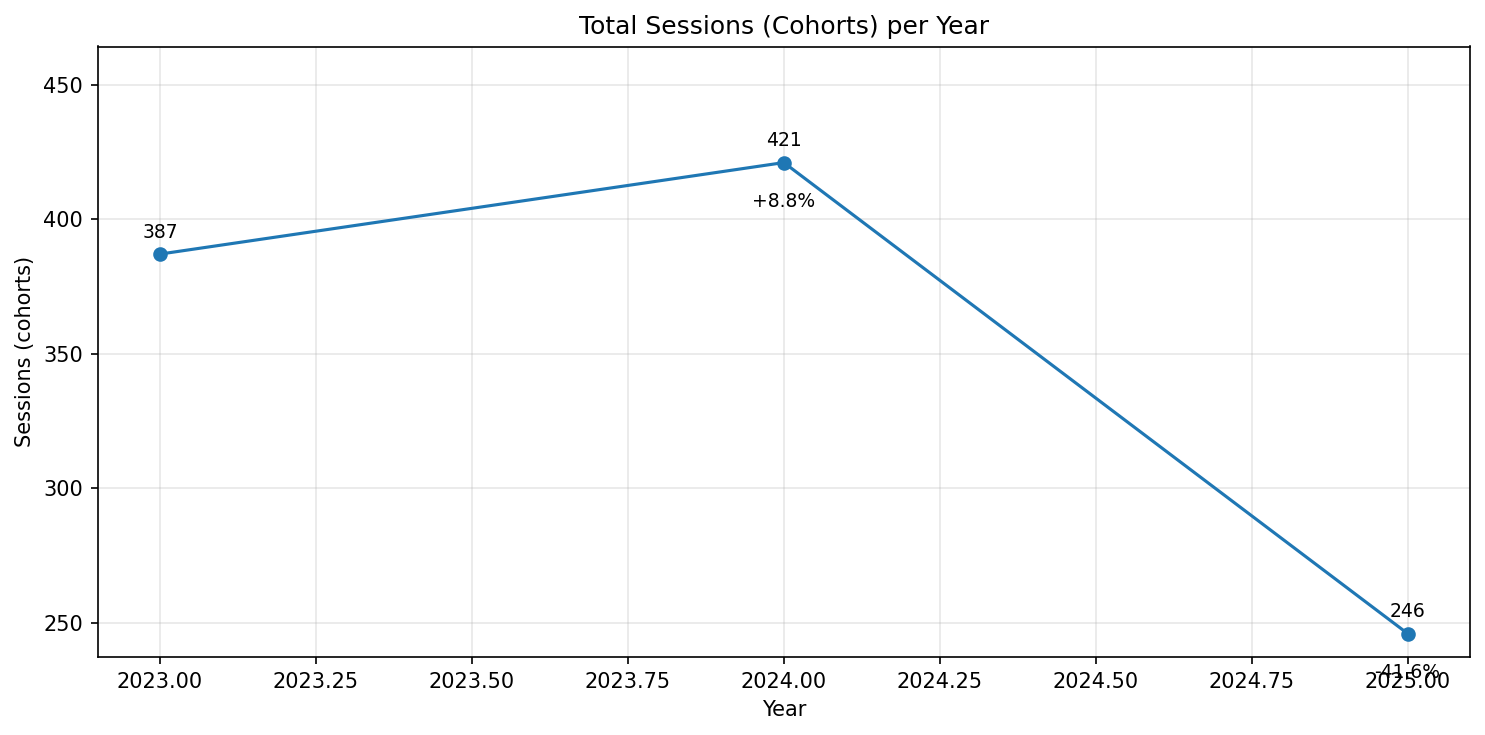

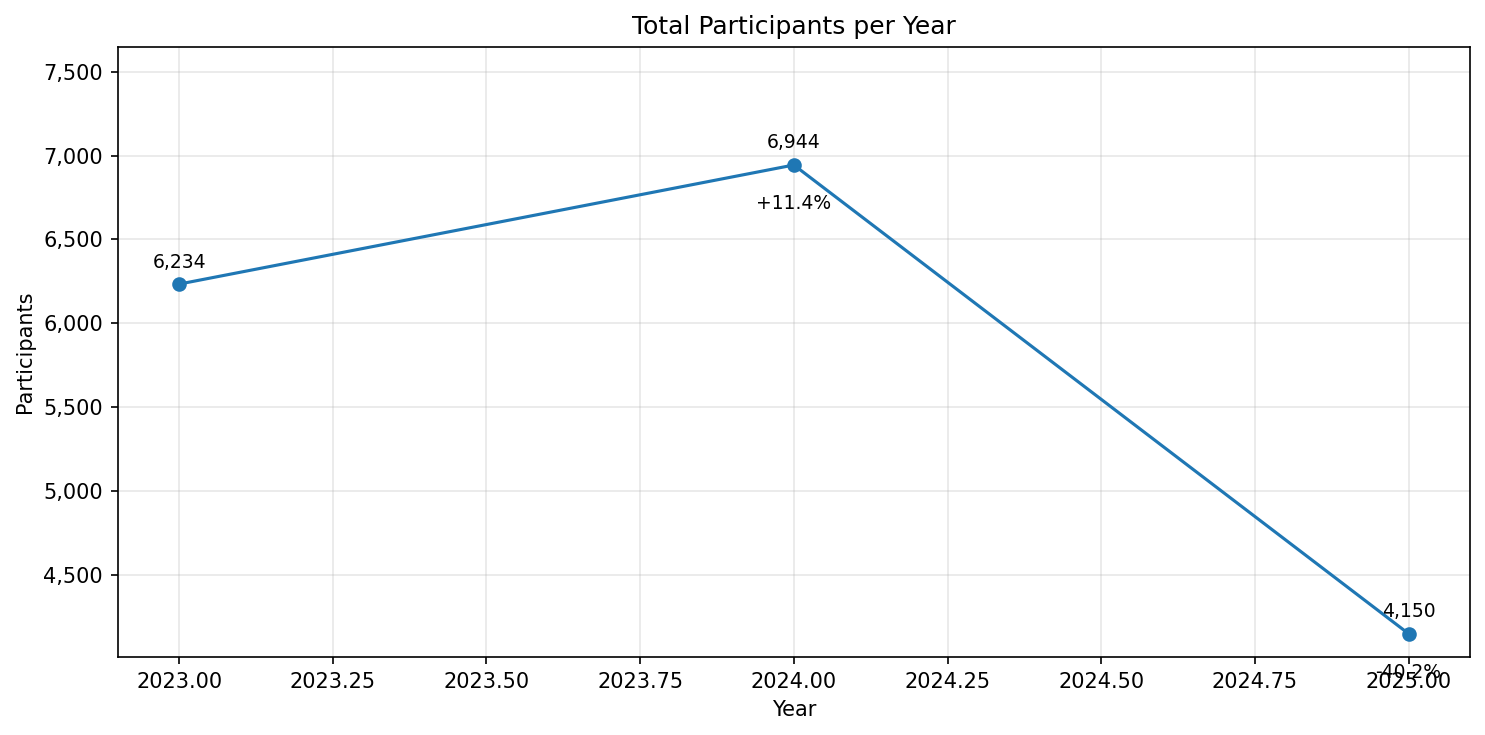

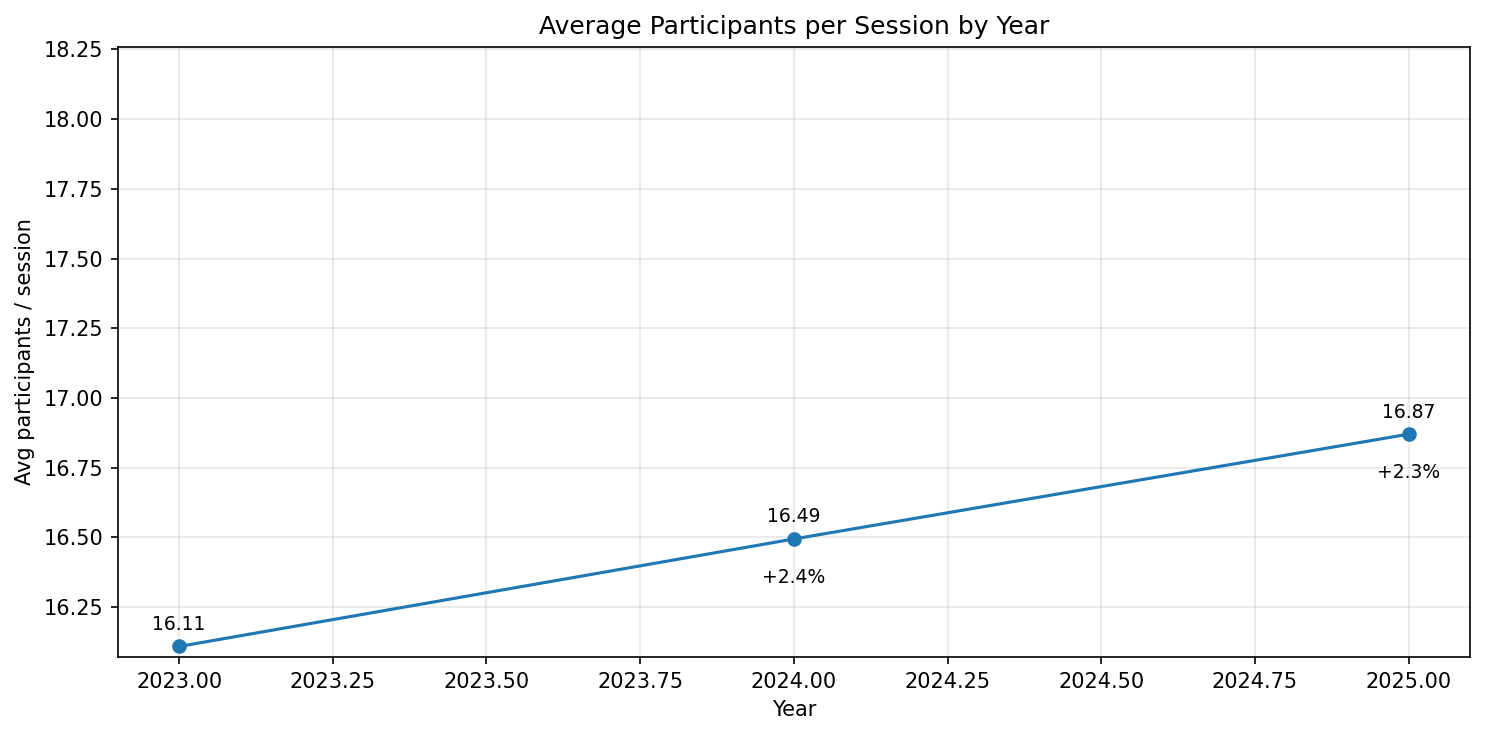

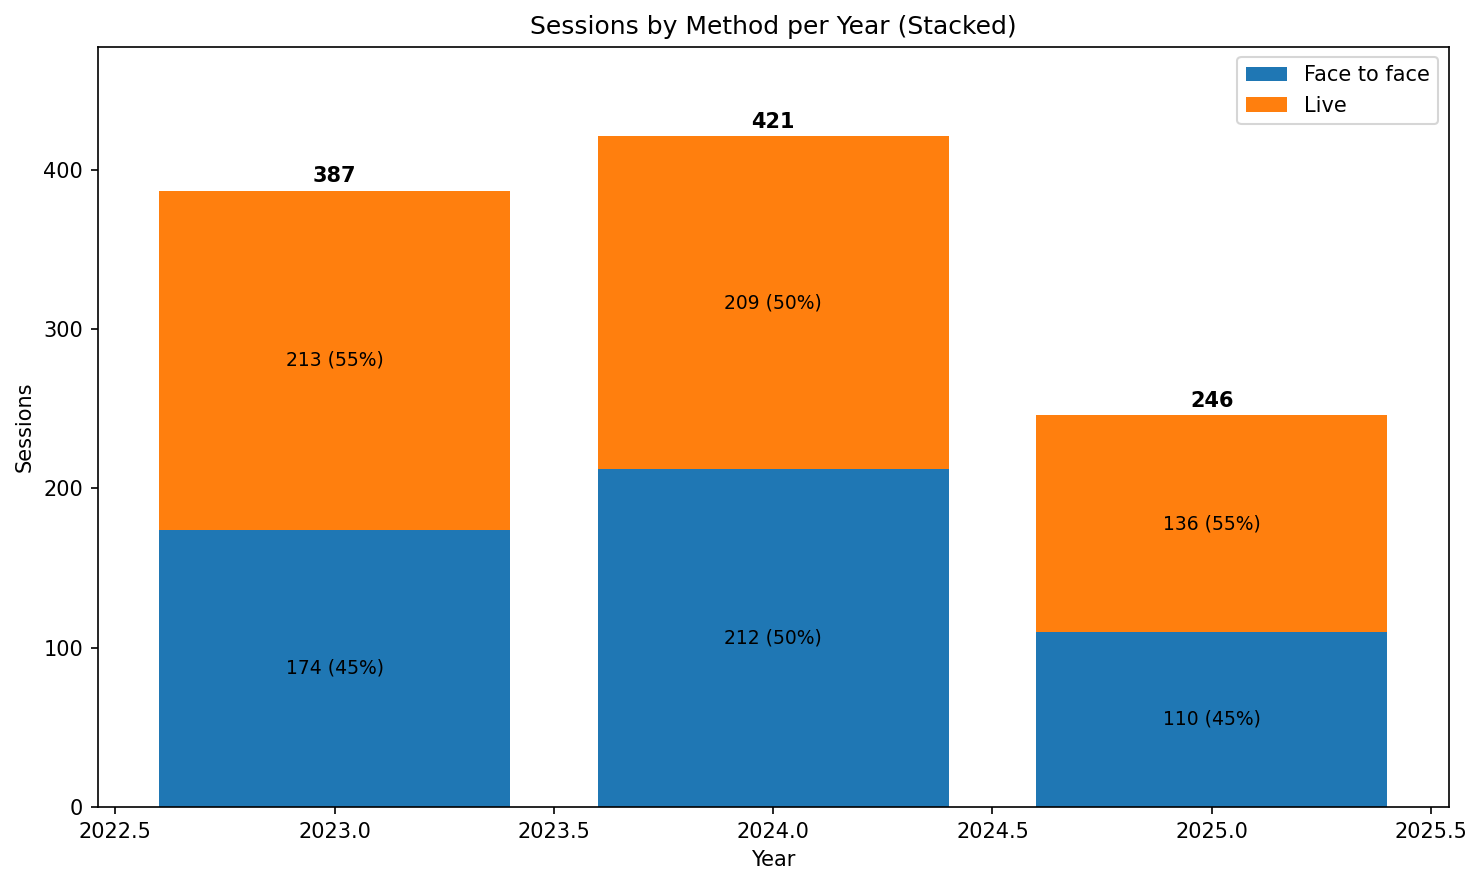

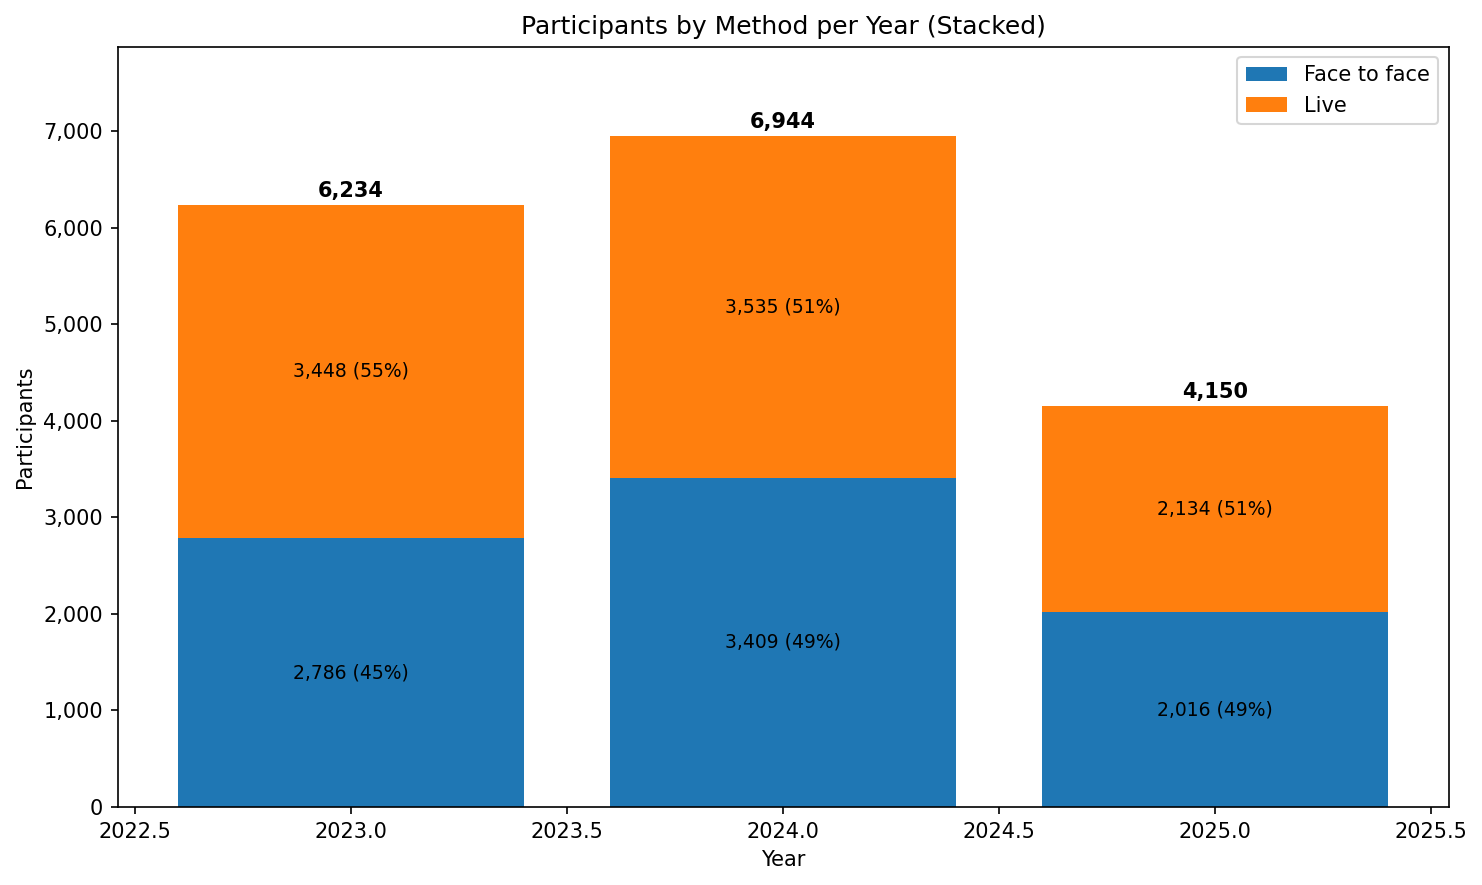

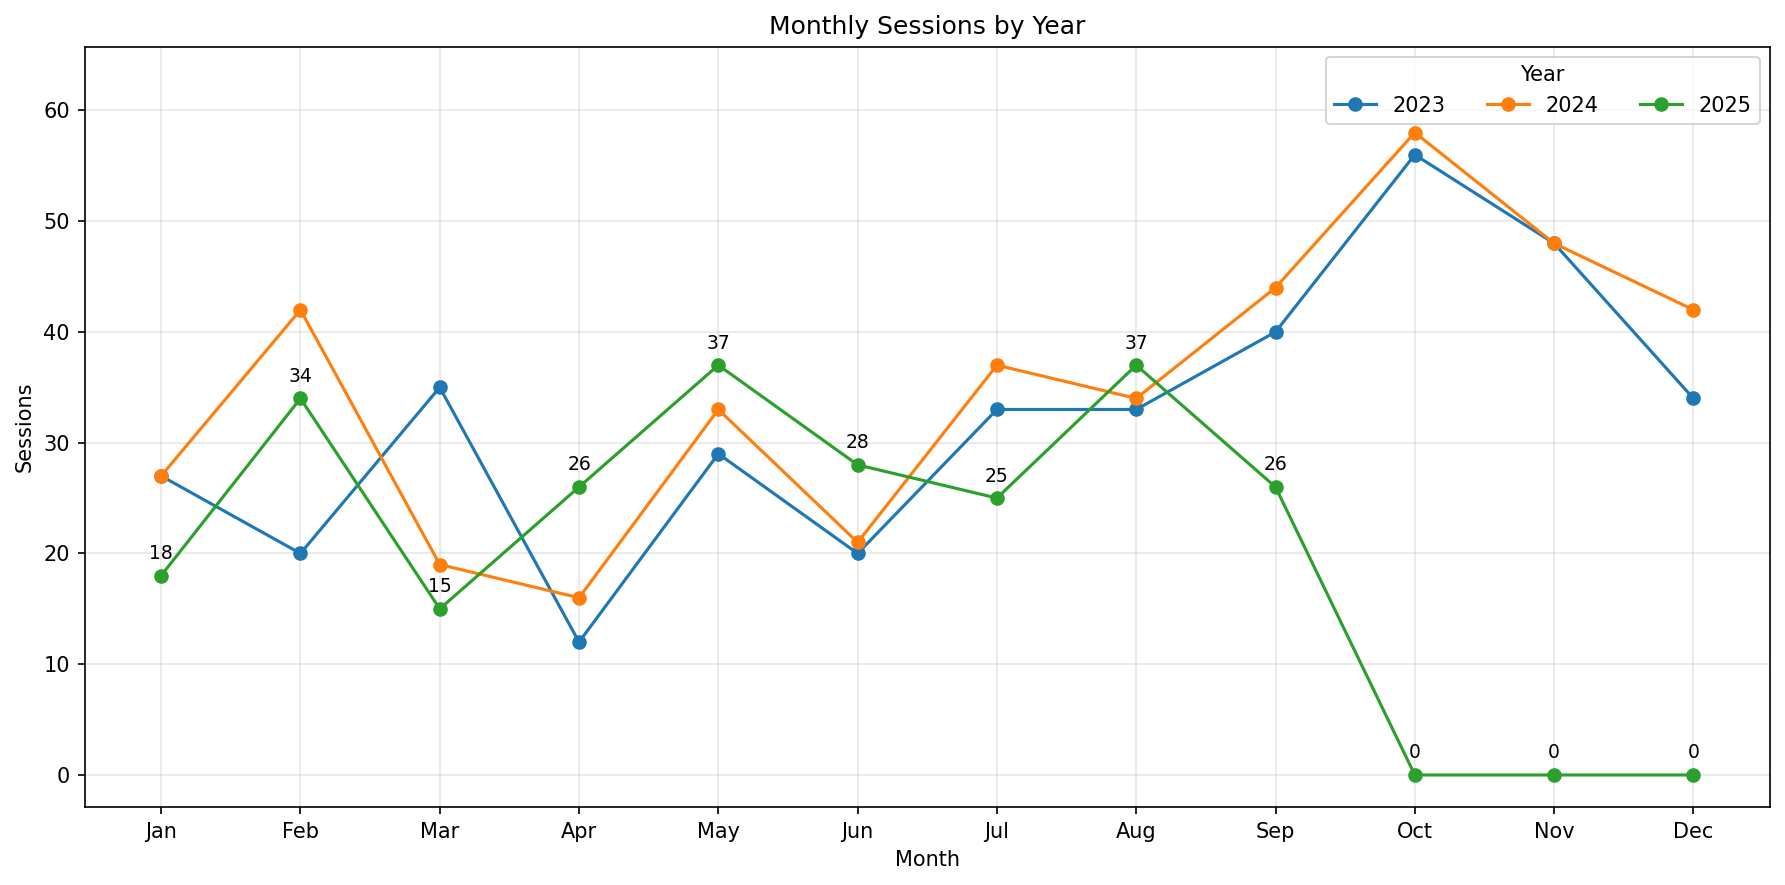

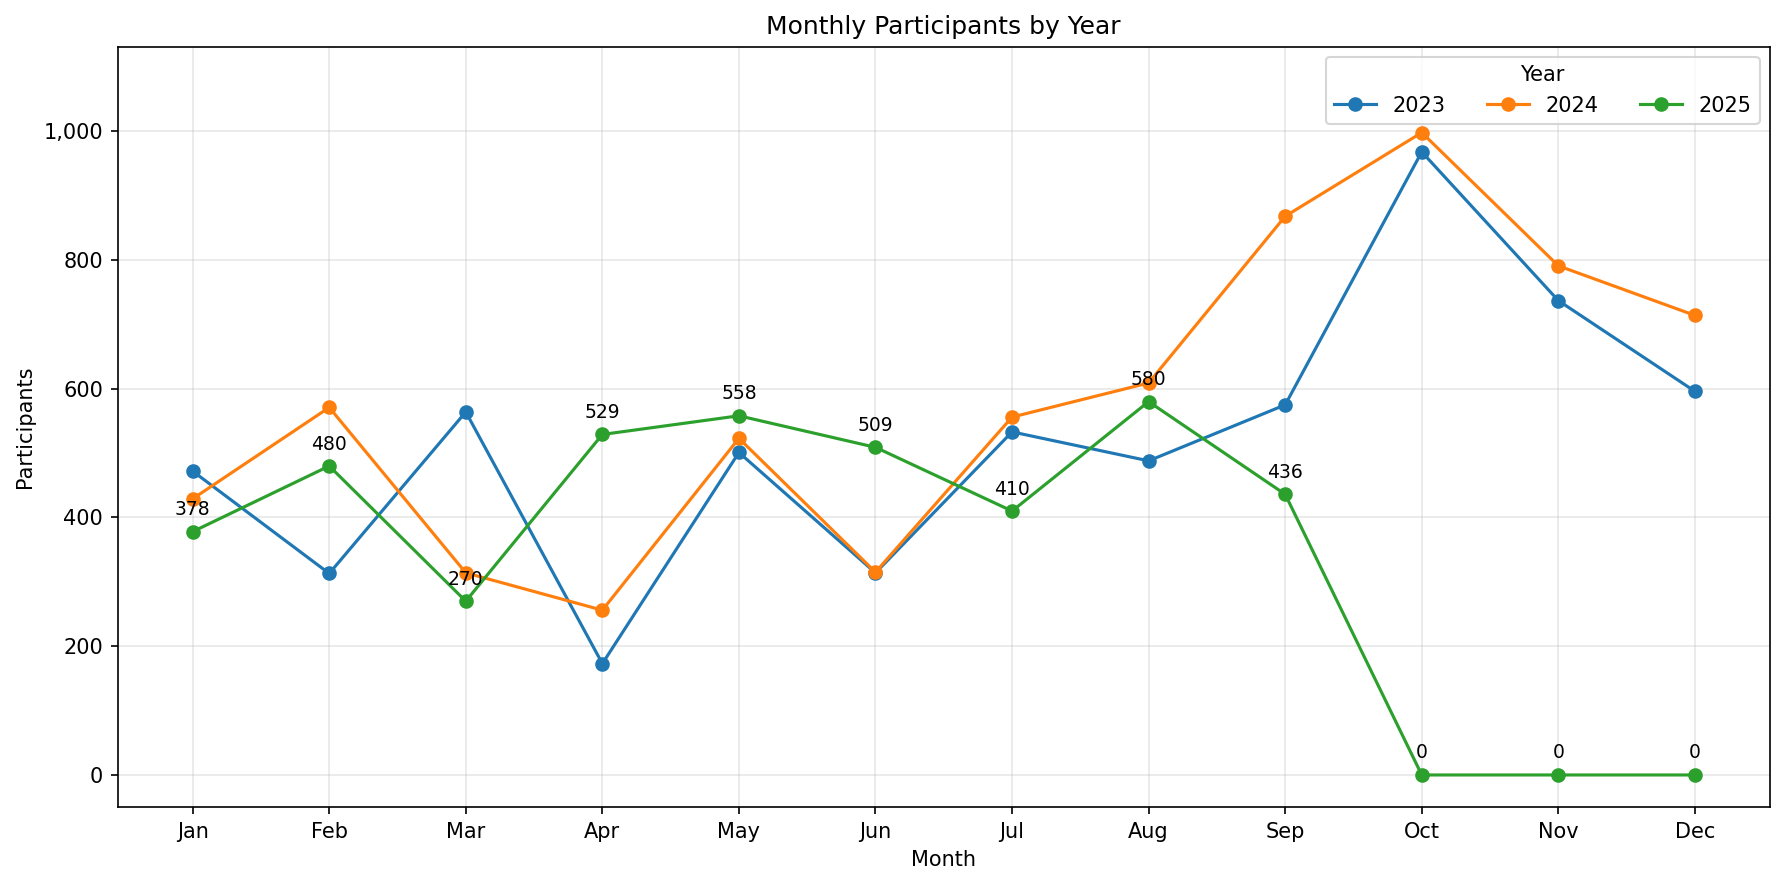

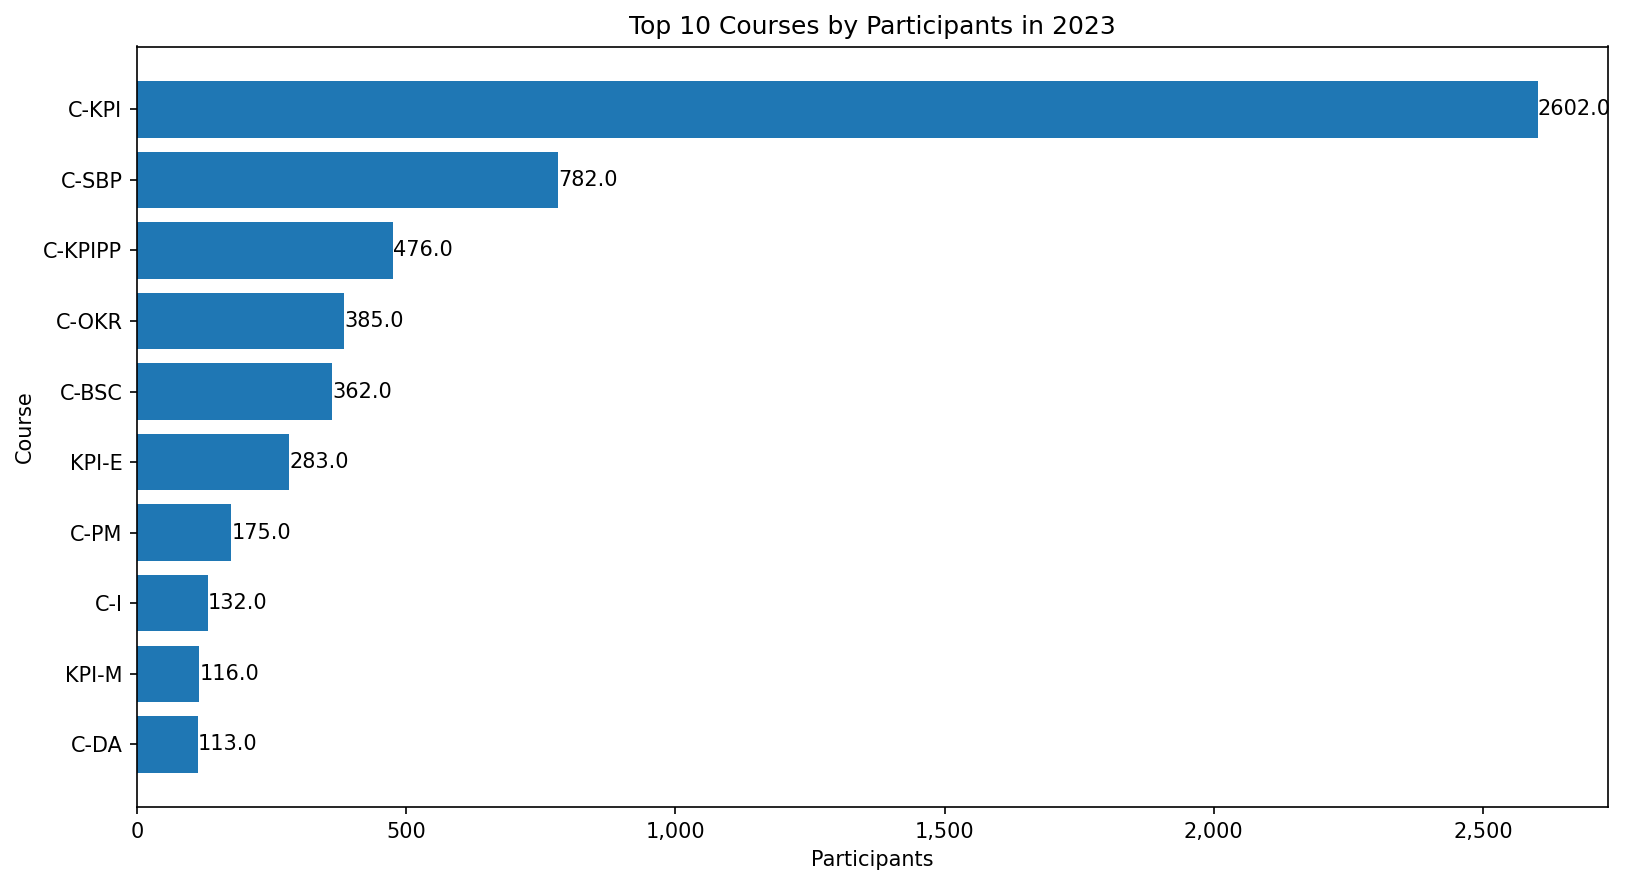

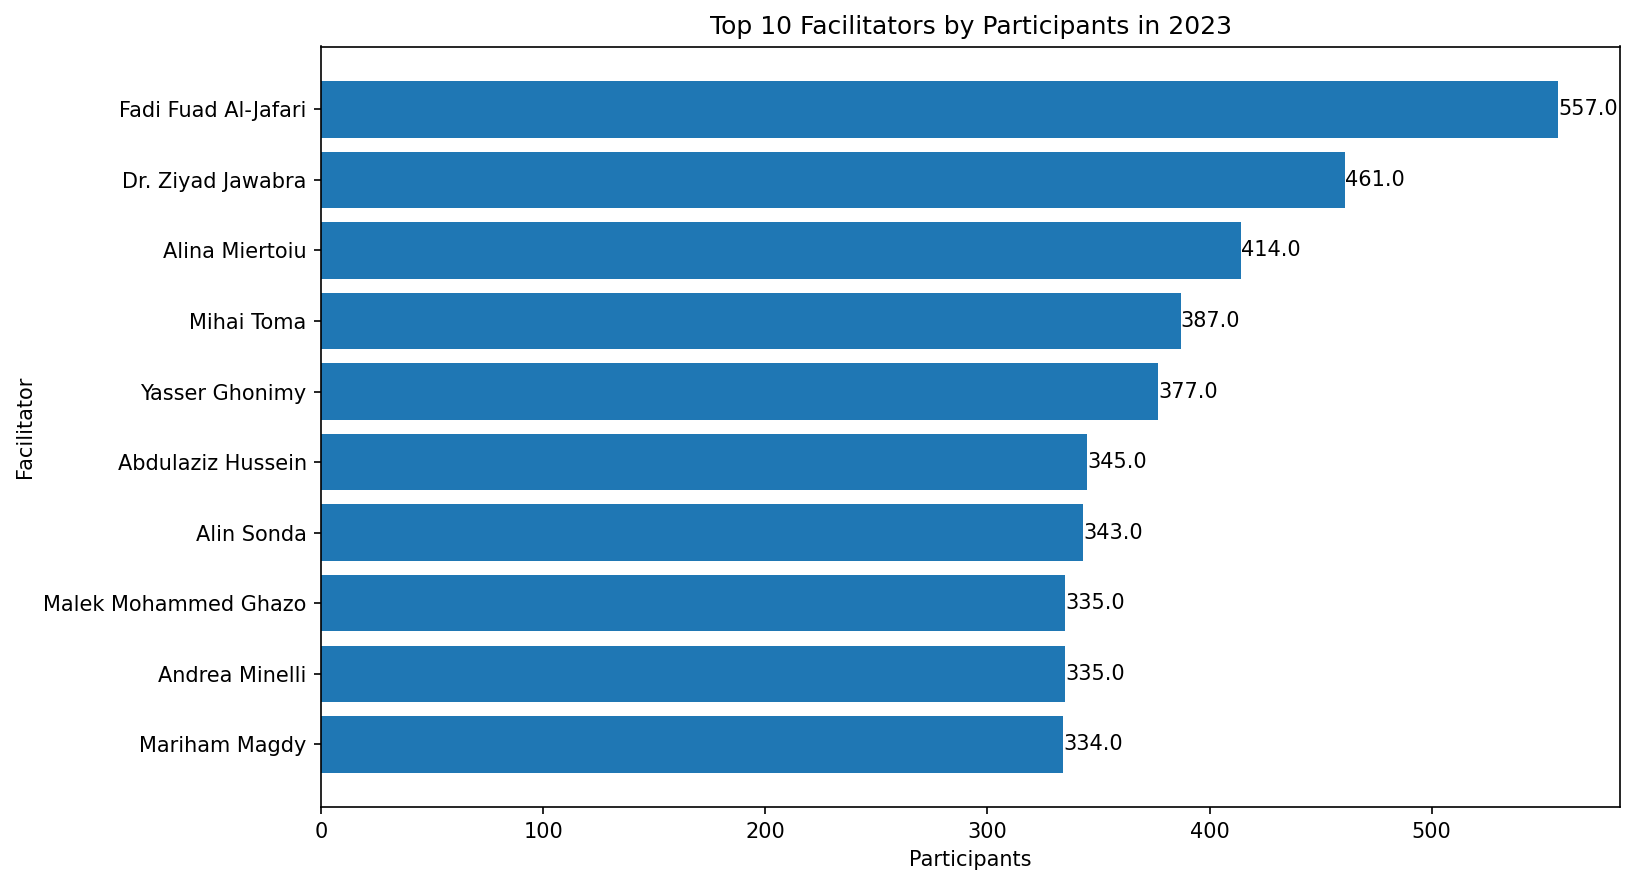

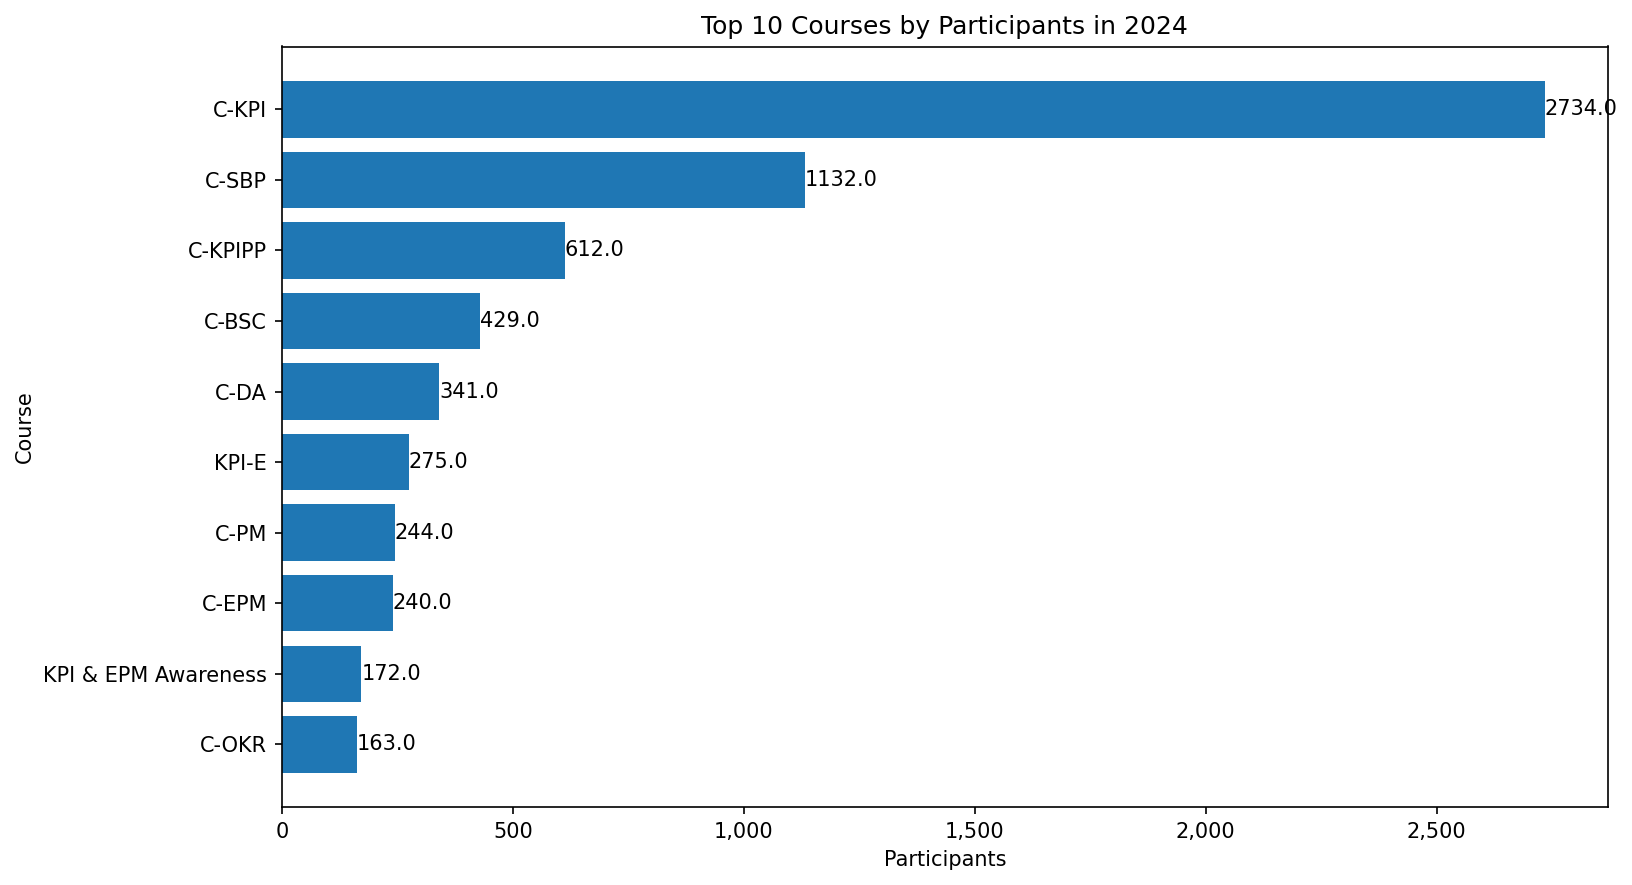

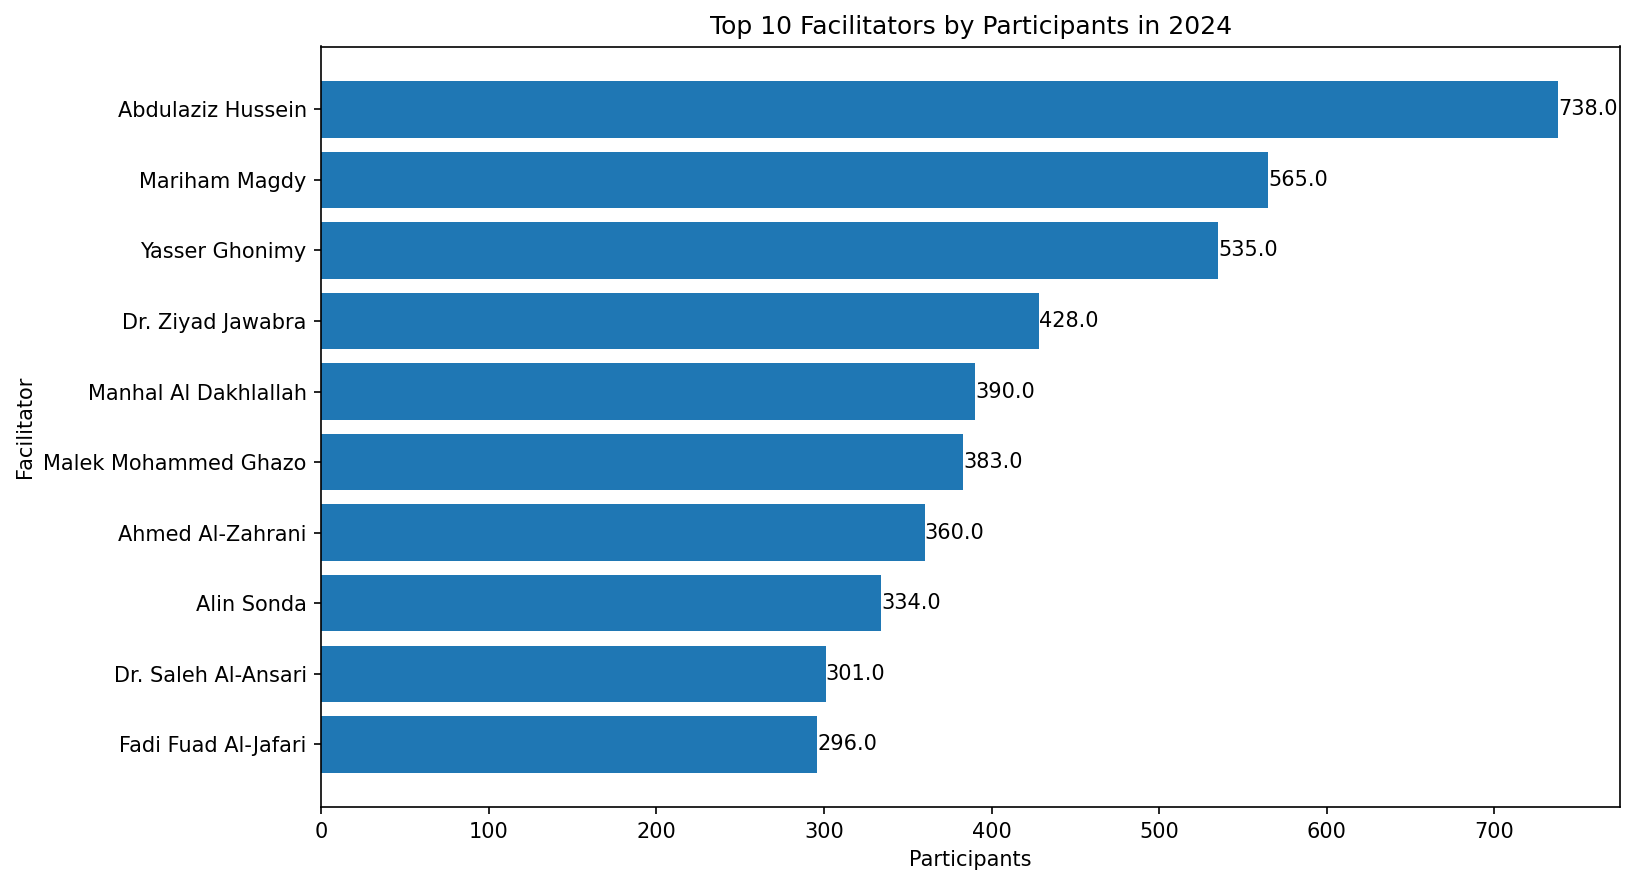

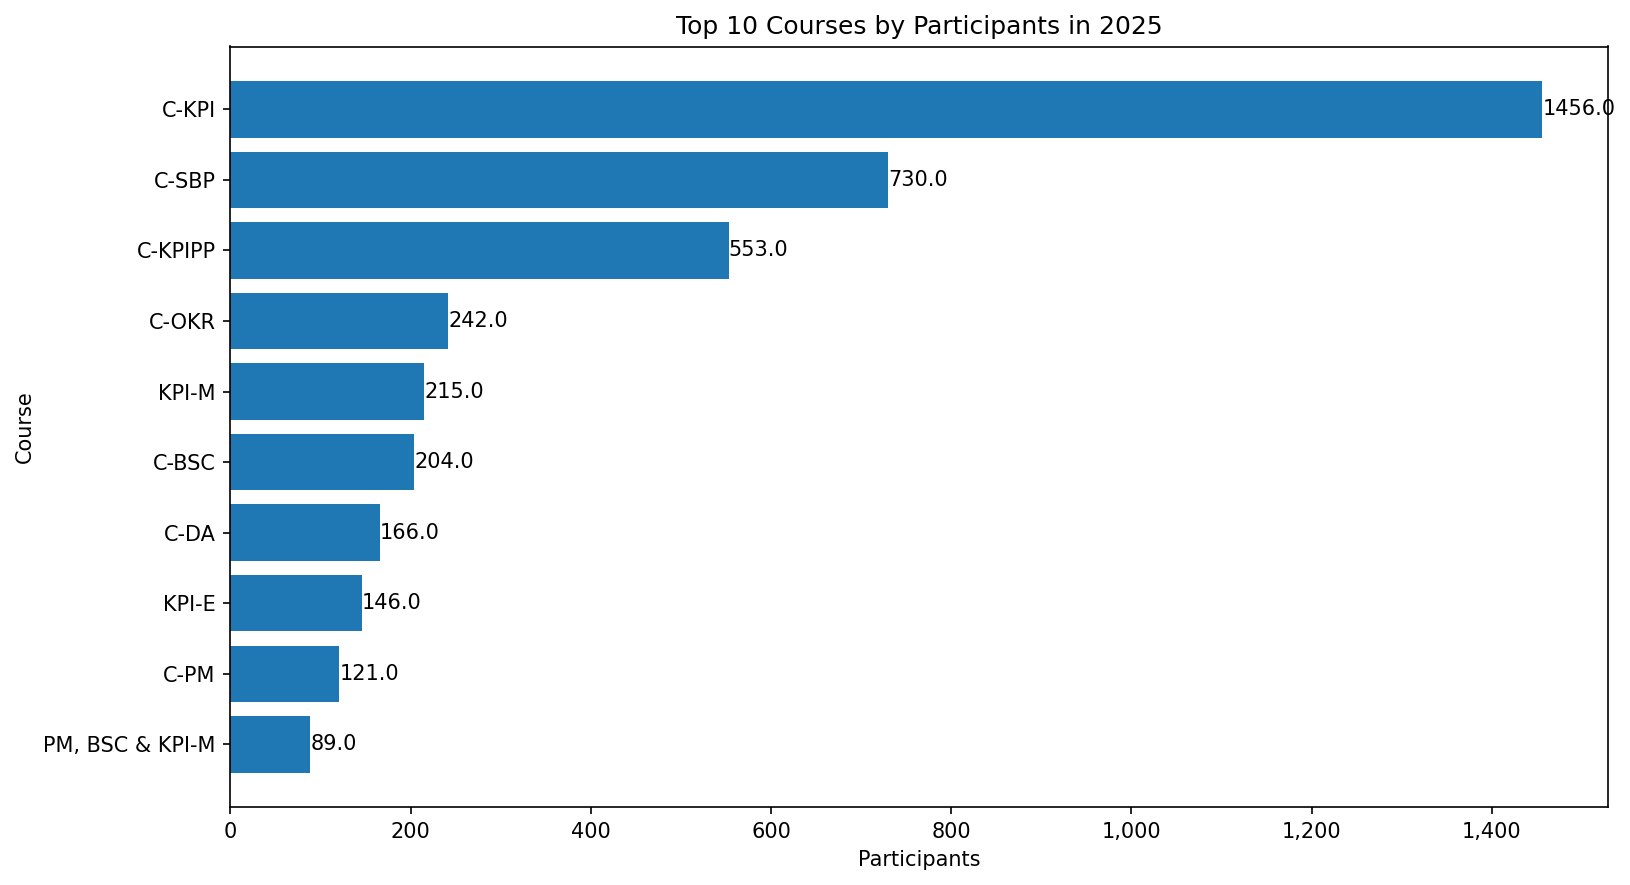

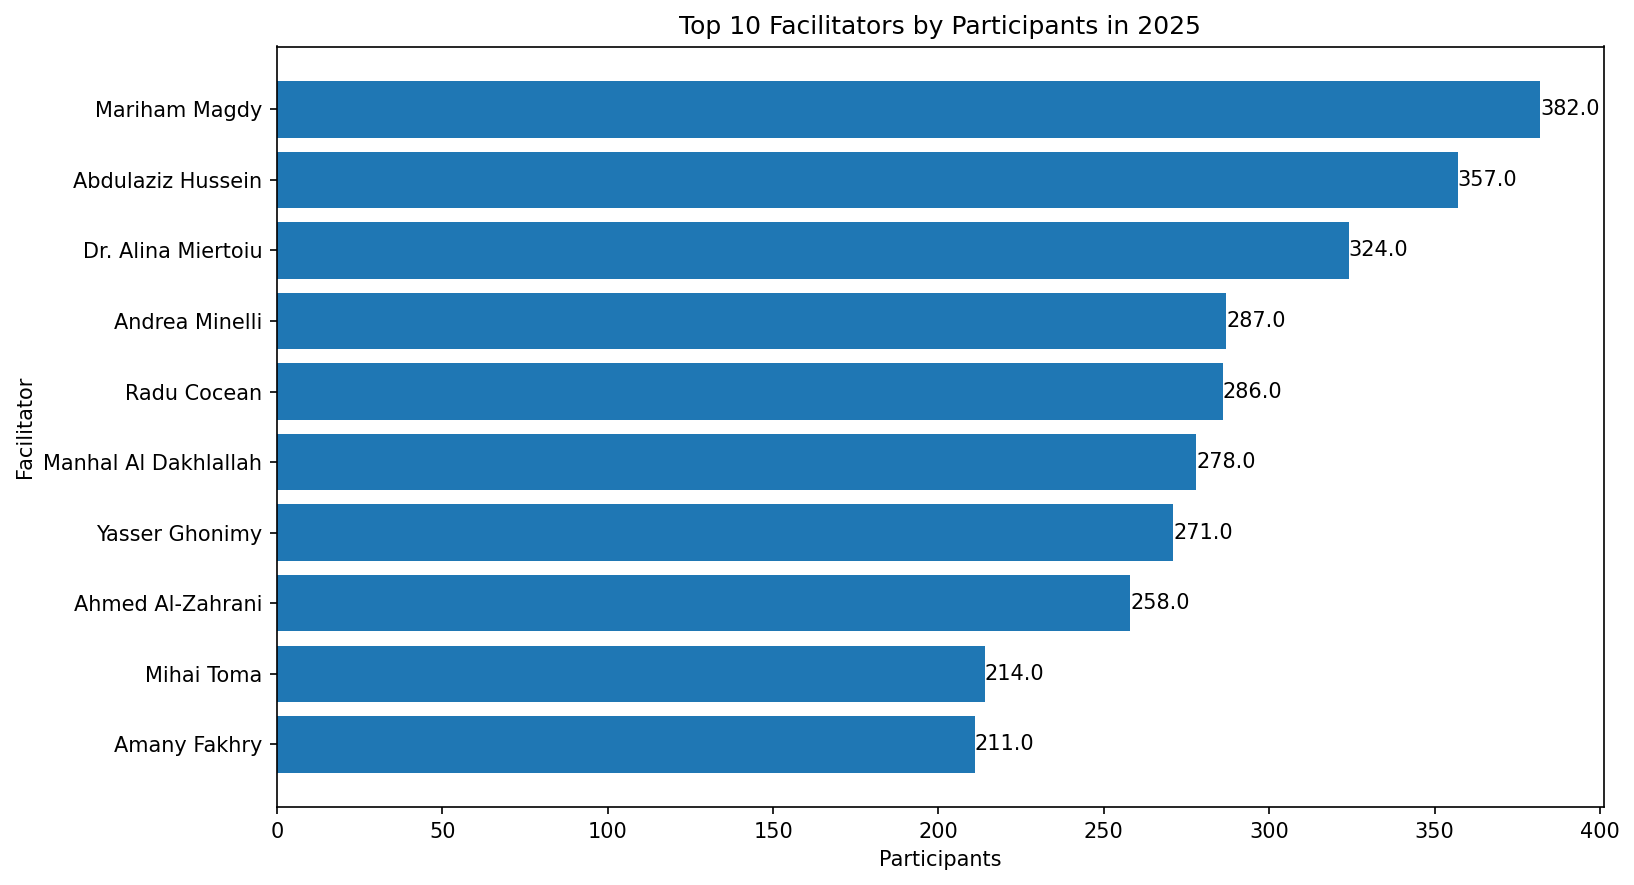

Saved figures to: /kaggle/working/figures_better


In [19]:
# Inputs:
# - Expects `course_clean` DataFrame to exist.
# - Uses `Year` column if present; otherwise derives from Start/End date resolved.
# - Valid delivery methods are exactly ["Face to face", "Live"].

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import textwrap

# -----------------------------
# Helper utilities
# -----------------------------
def fmt_thousands(x, pos=None):
    """Axis formatter with thousands separators and no decimals."""
    try:
        return f"{int(x):,}"
    except Exception:
        return str(x)

def fmt_decimal(x, decimals=2):
    """Format a float to N decimals with thousands separators."""
    if pd.isna(x):
        return ""
    return f"{x:,.{decimals}f}"

def add_headroom(ax, pct=0.05):
    """Add headroom to the upper y-limit for nicer label spacing."""
    ymin, ymax = ax.get_ylim()
    if np.isfinite(ymax):
        ax.set_ylim(ymin, ymax * (1 + pct if ymax > 0 else 1 - pct))

def label_line_points(ax, x_vals, y_vals, decimals=0):
    """Label each point on a line slightly above it."""
    for xv, yv in zip(x_vals, y_vals):
        if pd.isna(yv):
            continue
        ax.annotate(
            fmt_decimal(yv, decimals),
            xy=(xv, yv),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

def label_yoy_change(ax, x_vals, y_vals):
    """Annotate YoY % change next to each point (from previous point)."""
    for i in range(1, len(x_vals)):
        prev = y_vals[i - 1]
        curr = y_vals[i]
        if pd.isna(prev) or prev == 0 or pd.isna(curr):
            continue
        pct = (curr / prev - 1.0) * 100.0
        # place slightly below the point to avoid clashing with the value label
        ax.annotate(
            f"{pct:+.1f}%",
            xy=(x_vals[i], y_vals[i]),
            xytext=(0, -14),
            textcoords="offset points",
            ha="center",
            va="top",
            fontsize=9,
        )

def wrap_or_truncate(label, width=28, max_lines=2):
    """Wrap long labels to multiple lines; if still too long, truncate last line with ellipsis."""
    if not isinstance(label, str):
        return label
    wrapped = textwrap.wrap(label, width=width)
    if len(wrapped) <= max_lines:
        return "\n".join(wrapped)
    keep = wrapped[: max_lines - 1]
    last = wrapped[max_lines - 1]
    if len(last) > width:
        last = last[: max(0, width - 1)] + "…"
    keep.append(last)
    return "\n".join(keep)

def label_bar_values(ax):
    """Attach value labels to bars (vertical or horizontal)."""
    for container in ax.containers:
        try:
            ax.bar_label(container, fmt="{}")
        except Exception:
            pass

def label_stacked_segments_with_share(ax, stacked_df):
    """
    For stacked bars: label each segment as 'value (xx%)'.
    stacked_df: DataFrame indexed by x positions (years), columns = segments
    """
    totals = stacked_df.sum(axis=1).values
    for c_idx, container in enumerate(ax.containers):
        bars = list(container)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            total = totals[i] if i < len(totals) else 0
            if total > 0 and height > 0:
                pct = height / total * 100.0
                label = f"{int(height):,} ({pct:.0f}%)"
                ax.annotate(
                    label,
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    ha="center",
                    va="center",
                    fontsize=9,
                )

def add_stacked_totals(ax, x_positions, totals):
    """Add total labels on top of stacked bars."""
    ymin, ymax = ax.get_ylim()
    y_offset = (ymax - ymin) * 0.01
    for x, t in zip(x_positions, totals):
        ax.annotate(
            f"{int(t):,}",
            xy=(x, t),
            xytext=(0, 2),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

# -----------------------------
# 0) Prepare data safely
# -----------------------------
df = course_clean.copy()

# Ensure 'Year'
if "Year" not in df.columns:
    y_start = df["Start date resolved"].dt.year
    y_end = df["End date resolved"].dt.year
    df["Year"] = y_start.where(y_start.notna(), y_end).astype("Int64")

# Standardize 'Course Name' (if not already created)
if "Course Name" not in df.columns:
    if "acronym_map" in globals() and isinstance(acronym_map, dict):
        df["Course Name"] = (
            df["Course title"].astype(str).str.strip().map(acronym_map)
            .fillna(df["Course title"].astype(str).str.strip())
        )
    else:
        df["Course Name"] = df["Course title"].astype(str).str.strip()

# Keep only valid methods
valid_methods = ["Face to face", "Live"]
df = df[df["Method"].isin(valid_methods)].copy()

# Drop rows without a year
df = df.dropna(subset=["Year"]).copy()

# Numeric participants
df["Participants count"] = pd.to_numeric(df["Participants count"], errors="coerce").fillna(0)

# Month per row (prefer Start date resolved; else End date resolved)
date_src = df["Start date resolved"].where(df["Start date resolved"].notna(), df["End date resolved"])
df["Month"] = pd.to_datetime(date_src).dt.to_period("M").astype(str)  # "YYYY-MM"
df["Month_Num"] = pd.to_datetime(date_src).dt.month                   # 1..12

# Sorted years
years = sorted(int(y) for y in df["Year"].dropna().unique())

# Output folder
fig_dir = Path("figures_better")
fig_dir.mkdir(exist_ok=True)

# Common number formatter on axes
thousands_formatter = FuncFormatter(fmt_thousands)

# -----------------------------
# (A) All-year trend charts (with labels + YoY)
# -----------------------------
yearly_sessions = df.groupby("Year").size().astype(int)
yearly_participants = df.groupby("Year")["Participants count"].sum().astype(int)
yearly_avg_pps = (yearly_participants / yearly_sessions).replace([np.inf, -np.inf], np.nan)

# 1) Sessions per year
x_years = yearly_sessions.index.astype(int).tolist()
y_vals = yearly_sessions.values.astype(float).tolist()
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()
ax.plot(x_years, y_vals, marker="o")
ax.set_title("Total Sessions (Cohorts) per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Sessions (cohorts)")
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(thousands_formatter)
label_line_points(ax, x_years, y_vals, decimals=0)
label_yoy_change(ax, x_years, y_vals)
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "all_years_sessions.png")
plt.show()

# 2) Participants per year
x_years = yearly_participants.index.astype(int).tolist()
y_vals = yearly_participants.values.astype(float).tolist()
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()
ax.plot(x_years, y_vals, marker="o")
ax.set_title("Total Participants per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Participants")
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(thousands_formatter)
label_line_points(ax, x_years, y_vals, decimals=0)
label_yoy_change(ax, x_years, y_vals)
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "all_years_participants.png")
plt.show()

# 3) Avg participants per session
x_years = yearly_avg_pps.index.astype(int).tolist()
y_vals = yearly_avg_pps.values.astype(float).tolist()
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()
ax.plot(x_years, y_vals, marker="o")
ax.set_title("Average Participants per Session by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Avg participants / session")
ax.grid(True, alpha=0.3)
label_line_points(ax, x_years, y_vals, decimals=2)
label_yoy_change(ax, x_years, y_vals)
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "all_years_avg_pps.png")
plt.show()

# 4) Sessions by method per year (stacked) with segment shares + total
sessions_method = (
    df.groupby(["Year", "Method"])
      .size().unstack("Method", fill_value=0)
      .reindex(index=years)
)
plt.figure(figsize=(10, 6), dpi=150)
ax = plt.gca()
bottom = np.zeros(len(sessions_method))
x_pos = np.array(sessions_method.index.astype(int))
for meth in valid_methods:
    vals = sessions_method[meth].values if meth in sessions_method.columns else np.zeros(len(sessions_method))
    ax.bar(x_pos, vals, bottom=bottom, label=meth)
    bottom = bottom + vals
ax.set_title("Sessions by Method per Year (Stacked)")
ax.set_xlabel("Year")
ax.set_ylabel("Sessions")
ax.yaxis.set_major_formatter(thousands_formatter)
ax.legend()
label_stacked_segments_with_share(ax, sessions_method)
add_stacked_totals(ax, x_pos, sessions_method.sum(axis=1).values)
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "all_years_sessions_by_method.png")
plt.show()

# 5) Participants by method per year (stacked) with segment shares + total
participants_method = (
    df.groupby(["Year", "Method"])["Participants count"]
      .sum().unstack("Method", fill_value=0)
      .reindex(index=years)
)
plt.figure(figsize=(10, 6), dpi=150)
ax = plt.gca()
bottom = np.zeros(len(participants_method))
x_pos = np.array(participants_method.index.astype(int))
for meth in valid_methods:
    vals = participants_method[meth].values if meth in participants_method.columns else np.zeros(len(participants_method))
    ax.bar(x_pos, vals, bottom=bottom, label=meth)
    bottom = bottom + vals
ax.set_title("Participants by Method per Year (Stacked)")
ax.set_xlabel("Year")
ax.set_ylabel("Participants")
ax.yaxis.set_major_formatter(thousands_formatter)
ax.legend()
label_stacked_segments_with_share(ax, participants_method)
add_stacked_totals(ax, x_pos, participants_method.sum(axis=1).values)
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "all_years_participants_by_method.png")
plt.show()

# -----------------------------
# (B) NEW: Combined monthly charts (one figure each) — multiple years as separate lines
# -----------------------------
# Sessions per month across years (lines by year)
monthly_sessions_by_year = (
    df.groupby(["Year", "Month_Num"])
      .size()
      .rename("Sessions")
      .reset_index()
)

# Ensure all months 1..12 exist per year (fill missing with 0)
all_months = pd.DataFrame({"Month_Num": np.arange(1, 13, dtype=int)})
lines_sessions = {}
for y in years:
    temp = monthly_sessions_by_year[monthly_sessions_by_year["Year"] == y][["Month_Num", "Sessions"]]
    temp = all_months.merge(temp, on="Month_Num", how="left").fillna(0)
    lines_sessions[y] = temp["Sessions"].astype(float).tolist()

plt.figure(figsize=(12, 6), dpi=150)
ax = plt.gca()
months_xticks = np.arange(1, 13, dtype=int)
for y in years:
    ax.plot(months_xticks, lines_sessions[y], marker="o", label=str(y))
# Labels on points for the last year only (to reduce clutter) or label all years if desired:
# for y in years:
#     label_line_points(ax, months_xticks, lines_sessions[y], decimals=0)
# Here: label the latest year prominently
if len(years) > 0:
    latest = years[-1]
    label_line_points(ax, months_xticks, lines_sessions[latest], decimals=0)

ax.set_title("Monthly Sessions by Year")
ax.set_xlabel("Month")
ax.set_ylabel("Sessions")
ax.set_xticks(months_xticks)
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.yaxis.set_major_formatter(thousands_formatter)
ax.grid(True, alpha=0.3)
ax.legend(title="Year", ncol=min(len(years), 6))
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "combined_monthly_sessions_by_year.png")
plt.show()

# Participants per month across years (lines by year)
monthly_participants_by_year = (
    df.groupby(["Year", "Month_Num"])["Participants count"]
      .sum()
      .rename("Participants")
      .reset_index()
)

lines_participants = {}
for y in years:
    temp = monthly_participants_by_year[monthly_participants_by_year["Year"] == y][["Month_Num", "Participants"]]
    temp = all_months.merge(temp, on="Month_Num", how="left").fillna(0)
    lines_participants[y] = temp["Participants"].astype(float).tolist()

plt.figure(figsize=(12, 6), dpi=150)
ax = plt.gca()
for y in years:
    ax.plot(months_xticks, lines_participants[y], marker="o", label=str(y))
# Label only the latest year's points to avoid clutter
if len(years) > 0:
    latest = years[-1]
    label_line_points(ax, months_xticks, lines_participants[latest], decimals=0)

ax.set_title("Monthly Participants by Year")
ax.set_xlabel("Month")
ax.set_ylabel("Participants")
ax.set_xticks(months_xticks)
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.yaxis.set_major_formatter(thousands_formatter)
ax.grid(True, alpha=0.3)
ax.legend(title="Year", ncol=min(len(years), 6))
add_headroom(ax, pct=0.08)
plt.tight_layout()
plt.savefig(fig_dir / "combined_monthly_participants_by_year.png")
plt.show()

# -----------------------------
# (C) Per-year TOPS (kept as before)
# -----------------------------
for y in years:
    df_y = df[df["Year"] == y].copy()

    # Top 10 courses by participants (horizontal bars + wrapped names + labels)
    top_courses = (
        df_y.groupby("Course Name")["Participants count"]
            .sum().sort_values(ascending=False).head(10)
    )
    labels_wrapped = [wrap_or_truncate(s) for s in top_courses.index[::-1]]
    plt.figure(figsize=(11, 6), dpi=150)
    ax = plt.gca()
    ax.barh(labels_wrapped, top_courses.values[::-1])
    ax.set_title(f"Top 10 Courses by Participants in {y}")
    ax.set_xlabel("Participants")
    ax.set_ylabel("Course")
    ax.xaxis.set_major_formatter(thousands_formatter)
    label_bar_values(ax)
    plt.tight_layout()
    plt.savefig(fig_dir / f"{y}_top10_courses_participants.png")
    plt.show()

    # Top 10 facilitators by participants (horizontal bars + wrapped names + labels)
    top_fac = (
        df_y.groupby("Facilitator")["Participants count"]
            .sum().sort_values(ascending=False).head(10)
    )
    labels_wrapped = [wrap_or_truncate(s) for s in top_fac.index[::-1]]
    plt.figure(figsize=(11, 6), dpi=150)
    ax = plt.gca()
    ax.barh(labels_wrapped, top_fac.values[::-1])
    ax.set_title(f"Top 10 Facilitators by Participants in {y}")
    ax.set_xlabel("Participants")
    ax.set_ylabel("Facilitator")
    ax.xaxis.set_major_formatter(thousands_formatter)
    label_bar_values(ax)
    plt.tight_layout()
    plt.savefig(fig_dir / f"{y}_top10_facilitators_participants.png")
    plt.show()

print(f"Saved figures to: {fig_dir.resolve()}")